In [67]:
import gc
import gc, re
import time
import numpy as np
import xgboost as xgb
import pickle
import cx_Oracle as orcl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from datetime import datetime
from matplotlib import rc
from sklearn.svm import l1_min_c
#from sklearn.cross_validation import cross_val_score,train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,precision_recall_curve,auc
from sklearn.metrics import make_scorer, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import lasso_path, enet_path,LassoCV, LassoLarsCV, LassoLarsIC
#from sklearn import cross_validation,ensemble, datasets, grid_search, linear_model, metrics,tree


from itertools import cycle

'''
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 1300)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
'''

"\npd.set_option('display.height', 1000)\npd.set_option('display.max_rows', 1300)\npd.set_option('display.max_columns', 500)\npd.set_option('display.width', 1000)\n"

## Load Data

In [46]:
import cx_Oracle
con1 = cx_Oracle.connect('HCKZ_RSHAIMAGAMBETOV/g#e44ep2d123@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')

In [3]:
%%time
import pandas as pd
sql_str1 ='''
select * from ap_crm.T_RS_ABT_CASH_ALL_SMS10_0209TR sample(47.38)

'''
df = pd.read_sql_query(sql_str1, con1)
df_query = df.copy()

CPU times: user 1min 49s, sys: 5.31 s, total: 1min 54s
Wall time: 1min 56s


In [4]:
df_query.shape

(200034, 599)

In [5]:
df_query.head(2)

SKP_CLIENT     MONTH_  SD_AGE SD_FLAG_PENSIONER SD_NAME_CITY  \
0          27 2018-12-01    64.9                 Y       Алматы   
1          29 2018-11-01    54.1                 N      Зеренда   

   SD_AMT_INCOME_MAIN  SD_AMT_INCOME_OTHER SD_PREFERRED_LANGUAGE  \
0            100000.0                  0.0               Русский   
1            150000.0                  0.0               Русский   

   SD_AGE_MONTH SD_CODE_GENDER       ...        FCB_CNT_CONTRACT_CAR  \
0        778.45              F       ...                         NaN   
1        649.55              M       ...                         NaN   

  FCB_CNT_CONTRACT_MOR  FCB_CNT_CONTRACT_BIZ FCB_CNT_CONTRACT_ACT  \
0                  NaN                   NaN                  NaN   
1                  NaN                   NaN                  NaN   

  FCB_CNT_CONTRACT_LOAN_ACT FCB_CNT_CONTRACT_CARD_ACT  \
0                       NaN                       NaN   
1                       NaN                       NaN   

  FCB_CNT_CONTRACT_CAR_ACT  FCB_CNT_CONTRACT_MOR_ACT FCB_CNT_CONTRACT_BIZ_ACT  \
0                      NaN                       NaN                      NaN   
1                      NaN                       NaN                      NaN   

  FLAG_APPLICATION  
0                1  
1                1  

[2 rows x 599 columns]

### Функция PSI

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer, LabelEncoder
import tqdm
import warnings

def psihbkz(df,features):
    


    numerical_features=features
    categorical_features=[]
    
    
    def psi(pk, qk):
        if type(pk) != type(qk):
            return np.nan
        if len(pk) != len(qk):
            raise ValueError('len(pk) != len(qk)')
        pk, qk = np.array(pk), np.array(qk)
        m = (pk == 0) & (qk == 0)
        pk, qk = pk[~m], qk[~m]
        if any((pk == 0) | (qk == 0)):
            pk = (np.array(pk) + 1.0) / (1 + len(pk))
            qk = (np.array(qk) + 1.0) / (1 + len(qk))
        if sum(pk) < 1 - 1.e-2:
            raise ValueError('sum(pk) = 1.'.format(sum(pk)))
        if sum(qk) < 1 - 1.e-2:
            raise ValueError('sum(qk) = {} != 1.'.format(sum(qk)))

        return np.sum((pk - qk) * np.log(pk / qk), axis=0)

    def binns_report(df_binns, f, time_axis, uid="msisdn", title=None, pdf=None, only_bad=None):

        xfmt = mdates.DateFormatter('%y-%m-%d')

        dfg = df_binns.fillna(-1).groupby([time_axis, f]).agg({uid: np.size}).reset_index()
        dfg.sort_values(by=time_axis, inplace=True)
        for t in dfg[time_axis]:
            ix = dfg[time_axis]==t
            dfg.loc[ix, "share"] = dfg.loc[ix, uid]/sum(dfg.loc[ix, uid])
        plt.style.use(u'seaborn-dark')
        df_pivot = dfg.pivot(time_axis, f)['share']
        ax = df_pivot.plot(kind='bar', stacked=True)
        df_pivot = df_pivot.reset_index().fillna(0)
        df_pivot['values'] = df_pivot.iloc[:, 1:].values.tolist()
        df_pivot['psi'] = [psi(x[0], x[1]) for x in zip(df_pivot.shift(1)['values'],df_pivot['values'])]
        df_pivot.plot(x=time_axis, y="psi", ax=ax, color="black")
        lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xticks(ax.get_xticks(), rotation=90, fontsize="12")
        ax.xaxis_date()
        #ax.xaxis.set_major_formatter(xfmt)
        xmax, xmin = 0, df_pivot.shape[0]
        plt.plot([xmin, xmax], [0.1, 0.1], 'b', ls="--")
        plt.plot([xmin, xmax], [0.25, 0.25], 'r', ls="--")
        plt.gca().set_ylim([0, 1])
        plt.tight_layout()
        plt.subplots_adjust(top=0.8)
        max_psi = max(df_pivot[df_pivot["psi"].notnull()]["psi"])
        if title:
            c = "black"
            if max_psi>0.25:
                c = "red"
                plt.title(title + ", max_psi="+"%.2f"%max_psi, fontsize=20,color=c)
            else:
                plt.title(title + ", max_psi="+"%.2f"%max_psi, fontsize=20,color=c)

        if pdf and not only_bad:
            pdf.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')

        if not only_bad:
            plt.show()
    class CountEncoder(BaseEstimator, TransformerMixin):
            '''
            import pandas as pd
            import nurpy as np
            df = pd.DataFrame(l'Al: ['a', 'b', 'b', 'at, 'a 1 rt.)
            >>> CountEncoder().fit transform(df).A.tolist()
            [0, 1, 1, 0, 0, 2]

            '''

            def __init__ (self):
                self.vc = dict()

            def fit(self, df, y=None):
                for col in df.select_dtypes(include=['object']):
                    # don't use 'noble counts(dropno=frue)!!!
                    # in case if jobLib njobs > 1 the behavior of np.nan key is not stable
                    entries = df[col].value_counts()
                    entries.loc['nan'] = df[col].isnull().sum()
                    entries = entries.sort_values(ascending=False).index
                    self.vc[col] = dict(zip(entries, range(len(entries))))

                return self

            def transform(self, X):
                res = X.copy()
                for col, mapping in self.vc.items():
                    res[col] = res[col].map(lambda x: mapping.get(x, mapping.get('nan', 0)))

                return res


    class FeaturesExtractor(BaseEstimator, TransformerMixin):


        def __init__(self, features):
            self.features=features

        def fit (self, x, y=None):
            return self

        def transform(self, df):
            features_low_case = list(map(str.upper, self.features))
            self.names = df.columns
            return df.loc[:, features_low_case]

        def get_feature_names(self):
            return self.names.tolist()


    class ToNumericTransformer(BaseEstimator, TransformerMixin):

        def fit(self, df, y=None):
            self.names = df.columns
            return self

        def transform(self, df):
            for col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            self.names = df.columns
            return df

        def get_feature_names(self):
            return self.names.tolist()

    class Binner(BaseEstimator, TransformerMixin):

        def __init__(self, nbins=20):
            self.nbins = nbins

        def fit(self, df, y=None):
            self.names = df.columns
            self.feature_bins = {}
            for f in tqdm.tqdm(df.columns):
                nbins_warn = 0
                nbins = self.nbins
                nvals = len(df[f].unique())
                nbins = min(nbins, nvals)
                print(f"{f} nvals:{nvals} nbins:{nbins}")
                while nbins > 0:
                    try:
                        pd.qcut(df[f], q=nbins)
                        break
                    except Exception:
                        nbins -= 1
                        nbins_warn = pd.qcut(df[f], q=20,duplicates='drop').value_counts().shape[0]
                if nbins == 0:
                    warnings.warn("Number of bins set to 0 for " + f)
                    self.feature_bins[f] = [np.nan]

                if nbins_warn > 0:
                    nbins = self.nbins
                    _, bins = pd.qcut(df[f], q=nbins, retbins =True, labels=range(nbins_warn),duplicates='drop')
                else:    
                    _, bins = pd.qcut(df[f], q=nbins, retbins =True, labels=range(nbins))

                self.feature_bins[f] = bins


        def transform(self, df):
            df_ret = df.copy()
            for f, bins in self.feature_bins.items():
                labels = range(len(bins)-1)
                if len(bins) > 0:
                    df_ret[f] = pd.to_numeric(pd.cut(df[f], bins=bins, include_lowest=True, labels=labels))
            return df_ret

        def get_feature_names(self):
            return self.names.tolist()

    class ScoringPipeline():

        def __init__(self, clf, keep_features=None):

            if keep_features is None:
                self.categorical_features = categorical_features
                self.numerical_features = numerical_features
            else:
                self.categorical_features = filter(lambda f: f in keep_features, categorical_features)
                self.numerical_features = filter(lambda f: f in keep_features, numerical_features)
            self.names = self.numerical_features + self.categorical_features

            categorical = Pipeline([('extractor', FeaturesExtractor(self.categorical_features)), ('coder', CountEncoder())])
            numerical = Pipeline([('exractors', FeaturesExtractor(self.numerical_features)), ('to_numeric', ToNumericTransformer())])

            feature_union = FeatureUnion([
                ('numerical', numerical),
                ('categorical', categorical)
                ])

            self.transformer = Pipeline([
                ('feature_union', feature_union)
                ]) 

            self.pipeline = Pipeline([
                ('transformer', self.transformer),
                ('xgb', clf)
                ])

        def transform(self, df):
            dft = self.transformer.fit_transform(df)
            return pd.DataFrame(dft, columns=self.names)

    class BinnerPipeline():

        def __init__(self, keep_features=None):
            if keep_features is None:
                self.categorical_features = categorical_features
                self.numerical_features = numerical_features
            else:
                self.categorical_features = filter(lambda f: f in keep_features, categorical_features)
                self.numerical_features = filter(lambda f: f in keep_features, numerical_features)

            self.names = self.numerical_features + self.categorical_features

            #categorical = Pipeline([(Wextractor', FeaturesExtractor(self.categorical_features)),
            #                         ('coder', CountEncoder()),
            #                        ('binner', Binner())])
            numerical = Pipeline([('exractor', FeaturesExtractor(self.names)),
                                ('coder', CountEncoder()),
                                ('to_numeric', ToNumericTransformer()),
                                ('binner', Binner())])
            #to pandas = ToPandasTransformer(self.names)
            #feature union = FeatureUnion([
            #                ('numerical', numerical),
            #                ('categorical', categorical)
            #                ])

            self.pipeline= Pipeline([
                ('extractor', numerical)
            ])   


    def date_to_str(data):
        tt = "NONE"
        if data.month < 10:
            tt = str(data.year) + "0" + str(data.month)
        else: 
            tt =  str(data.year) + str(data.month)
        return tt        

    
    bp = BinnerPipeline()
    binner = bp.pipeline
    binner.fit(df)
    df_bins = binner.transform(df)
    cols = df_bins.columns
    df_bins[["MONTH_","SKP_CLIENT"]] = df[["MONTH_","SKP_CLIENT"]]
    #df_bins["month"] = df["DATE_MONTH_VALID_FROM"].apply(lambda d: d[-4:-2] + "01")
    #df_bins["month"] = df["DATE_MONTH_VALID_FROM"].dt.date #df.DATE_MONTH_VALID_FROM.dt.month.map(str) + "_" +       df.DATE_MONTH_VALID_FROM.dt.year.map(str)
    #df_bins["month"] =  df.DATE_MONTH_VALID_FROM.dt.year.map(str) + df.DATE_MONTH_VALID_FROM.dt.month.map(str)
    df_bins["month"] = df['MONTH_'].apply(date_to_str)
    for c in cols:
        binns_report(df_bins,c,'month', uid = "SKP_CLIENT", title = c, pdf = None, only_bad=None)
    #return df_bins


In [8]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd
import gc, re

def prepare_df (df, isPrintFeatures=True, isGetDummies = True, isPrintDummies=True, trsh_hold=0.001):
    drop_feat_hcode = [
        #id
        'MONTH_',                                        
        'SKP_CLIENT',
        'CMP_DATE_VALID_FROM',
        'CMP_DATE_VALID_TO',
        'LC_DATE_LAST_PAYMENT'
        #'CMP_DATE_VALID_FROM',    
        #'CMP_DATE_VALID_TO',
        #'LC_DATE_LAST_PAYMENT',
        #1
        #'CNT_CAMPAIGN',
        #'CNT_CAMPAIGN_TERM_MONTH',
        #1
        #2
        #'RATE_EIR_AVG',
        #'RATE_EIR_LOAN_FIRST',
        #'RATE_EIR_LOAN_LAST',
        #'RATE_EIR_PREV_LOAN_MAX',
        #'RATE_INTEREST_LOAN_LAST',
        #2
        #даты
        #'DATE_BCKT_1_30_OVD_LAST',
        #'DATE_BCKT_31_60_OVD_LAST',
        #'DATE_BCKT_61_90_OVD_LAST',
        #'DATE_BIRTH',
        #'DATE_TRAN_CARD_CASH_LAST',
        #'DATE_TRAN_CARD_POS_LAST'
        ]
    df.drop(drop_feat_hcode, axis=1, inplace=True)

    # Cat Features 
    # преобразовываем int to obj
    #df = df.rename(index=str, columns={"OF_CODE_SEGMENT_NEW": "OF_CODE_SEGMENT_NEW_"})

    #flag_to_obj = ['CON_NFLAG_PCCD_ALL_N','CON_NFLAG_PCCD_ACT_N', 'OF_CODE_SEGMENT_NEW_']
    #df[flag_to_obj] = df[flag_to_obj].astype(str)
    flag_to_obj = []
    
    cat_feat_objects = df.columns[df.dtypes=='object']
    #cat_feat_objects = np.concatenate([cat_feat_objects,['OF_CODE_SEGMENT_NEW_']])
    #cat_feat_nflag = df.filter(regex='.*FLAG_').columns
    #cat_feat_nflag = [x for x in cat_feat_nflag if x not in flag_to_obj]

    #df[cat_feat_nflag]=df[cat_feat_nflag].astype(int)
    #df[cat_feat_nflag]=df[cat_feat_nflag].astype(str)

    #cat_feat_SK = df.filter(regex='.*SK.?_').columns
    #df[cat_feat_SK]=df[cat_feat_SK].astype(int)
    #df[cat_feat_SK]=df[cat_feat_SK].astype(str)

    cat_feat_all = list(set().union(cat_feat_objects))
    cat_feat_all.sort()

    df_categ_feat_ind = np.where(np.in1d(df.columns,cat_feat_all))[0]

    #isPrintFeatures= True
    if isPrintFeatures == True:
        print('[cat_feat_objects]')
        print('#' * 80)
        print ('\n'.join(str(p) for p in cat_feat_objects) )
        print ('\n')

        print('[cat_feat_nflag]')
        print('#' * 80)
        print( '\n'.join(str(p) for p in cat_feat_nflag) )
        print ('\n')

        print('[cat_feat_SK]')
        print('#' * 80)
        print( '\n'.join(str(p) for p in cat_feat_SK) )
        print ('\n')

        print('[cat_feat_all]')
        print('#' * 80)
        print ('\n'.join(str(p) for p in cat_feat_all) )
        print ('\n')

    #isGetDummies = True
    # Get Dummies
    df_dummy_categ_feat_ind = np.zeros([1])
    if isGetDummies == True:
        cat_feat_all_dumm = pd.get_dummies(df[cat_feat_all])

        #isPrintDummies= True
        if isPrintDummies == True:
            print('#' * 80)
            print('Count dummies columns')
            print(len(cat_feat_all_dumm.columns))
            #print(list(cat_feat_all_dumm.columns))

        #trsh_hold = 0.001 if 0 - all variables
        #VarianceThreshold for CatFeatures
        VT = VarianceThreshold(threshold=trsh_hold)
        VT.fit(cat_feat_all_dumm)
        VT_mask = VT.get_support()
        print( '{} features left'.format(VT_mask.sum()))
        print( '\n'.join(str(p) for p in cat_feat_all_dumm.columns[VT_mask]))

        #объединяем        
        df.drop(cat_feat_all, axis=1, inplace=True)
        df = pd.concat([df, cat_feat_all_dumm[cat_feat_all_dumm.columns[VT_mask]]], axis=1)

        df_dummy_categ_feat_ind = np.where(np.in1d(df.columns, cat_feat_all_dumm.columns[VT_mask]))[0]

        #убираем спец символы из названий столбцов категорий
        df.rename(columns=lambda x: x.replace('-', '_minus'), inplace=True)
        df.rename(columns=lambda x: x.replace('+', '_plus'), inplace=True)
        df.rename(columns=lambda x: re.sub(r"[\W ]", '_', x), inplace=True)
    return df, df_categ_feat_ind, df_dummy_categ_feat_ind

In [9]:
df, _ , _ = prepare_df(df, isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)

497 features left
CMP_NAME_[CEL][CASH_EXISTING_RBP_1M][31JUL2018]
CMP_NAME_[CEL][RBP_0.75m_for_XM_D][02AUG2018]
CMP_NAME_[CEL][RBP_0.75m_for_XM_D][06DEC2018]
CMP_NAME_[CEL][RBP_0.75m_for_XM_D][14NOV2018]
CMP_NAME_[CEL][RBP_0.75m_for_XM_D][19OCT2018]
CMP_NAME_[CEL][RBP_0.75m_for_XM_D][20NOV2018]
CMP_NAME_[CEL][RBP_0.75m_for_XM_D][22NOV2018]
CMP_NAME_[CEL][RBP_0.75m_for_XM_D][28JAN2019]
CMP_NAME_[CEL][RBP_0.75m_for_XM_E][06DEC2018]
CMP_NAME_[CEL][RBP_0.75m_for_XM_E][19OCT2018]
CMP_NAME_[CEL][RBP_0.75m_for_XM_E][20NOV2018]
CMP_NAME_[CEL][RBP_0.75m_for_XM_E][22NOV2018]
CMP_NAME_[CEL][RBP_0.75m_for_XM_E][26SEP2018]
CMP_NAME_[CEL][RBP_0.75m_for_XM_E][28JAN2019]
CMP_NAME_[CEL][RBP_0.75m_for_XM_F][06DEC2018]
CMP_NAME_[CEL][RBP_0.75m_for_XM_F][19OCT2018]
CMP_NAME_[CEL][RBP_0.75m_for_XM_F][20NOV2018]
CMP_NAME_[CEL][RBP_0.75m_for_XM_F][22NOV2018]
CMP_NAME_[CEL][RBP_0.75m_for_XM_F][26SEP2018]
CMP_NAME_[CEL][RBP_0.75m_for_XM_F][28JAN2019]
CMP_NAME_[CEL][RBP_1.5m_for_XM_B][02AUG2018]
CMP_NAME_[CEL][

In [10]:
df.shape

(200034, 1032)

In [11]:
df_query.shape

(200034, 599)

In [12]:
list(df.columns)

['SD_AGE',
 'SD_AMT_INCOME_MAIN',
 'SD_AMT_INCOME_OTHER',
 'SD_AGE_MONTH',
 'SD_CNT_CHILDREN',
 'SD_SHARE_INCOME_6_M_REG',
 'CMP_FLAG_RD_POOL',
 'CMP_AMT_OFFER',
 'CMP_CNT_CONTRACT_ACT',
 'CMP_AMT_CREDIT_ACT',
 'CMP_AMT_DEBT_ACT',
 'CMP_FLAG_EVER_CASH',
 'CMP_FLAG_EVER_CARD',
 'CMP_CNT_M_LAST_CASH_OPEN',
 'CMP_CNT_M_LAST_CASH_CLOSE',
 'CMP_CNT_M_LAST_CARD_OPEN',
 'CMP_CNT_M_LAST_CARD_CLOSE',
 'APP_CNT_M_LAST',
 'APP_CNT_M_LAST_CASH',
 'APP_CNT_M_LAST_CASH_XS',
 'APP_CNT_M_LAST_CARD',
 'APP_CNT_M_LAST_CARD_XS',
 'APP_CNT_M_LAST_POS',
 'APP_RATE_APROVAL',
 'APP_RATE_APROVAL_CASH',
 'APP_RATE_APROVAL_CARD',
 'APP_RATE_APROVAL_POS',
 'APP_RATE_APROVAL_XS',
 'APP_RATE_APROVAL_CASH_XS',
 'APP_RATE_APROVAL_CARD_XS',
 'APP_CNT_POS',
 'APP_CNT_CASH',
 'APP_CNT_CARD',
 'APP_CNT_XSELL',
 'APP_CNT_CASH_XS',
 'APP_CNT_CARD_XS',
 'APP_CNT_POS_ZP',
 'APP_CNT_POS_ST',
 'APP_CNT_CASH_3M',
 'APP_CNT_CASH_6M',
 'APP_CNT_CASH_12M',
 'APP_CNT_CASH_24M',
 'APP_CNT_POS_3M',
 'APP_CNT_POS_6M',
 'APP_CNT_POS_1

## Select Features

In [13]:
from scipy.stats import linregress

def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return r_value**2


def correlation(dataset, threshold, method='pearson'):
    start = time.clock()
    dataset_in=dataset.copy()
    Y = dataset_in.FLAG_APPLICATION
    dataset_in.drop(['FLAG_APPLICATION'],axis=1, inplace=True)
    
    X_Train_r2=[]
    for idx, name in  enumerate(dataset_in.columns):
        X_Train_r2.append([name,rsquared(dataset_in[name].values, Y)])
    X_Train_r2=pd.DataFrame(X_Train_r2, columns=['NAME','R2'], index=np.array(X_Train_r2)[:,0])

    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset_in.corr().abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname_row = corr_matrix.index[j] # getting the name of index(row name)
                colname_col = corr_matrix.columns[i] # getting the name of column
                if X_Train_r2.loc[colname_row].R2> X_Train_r2.loc[colname_col].R2:
                    colname=colname_col
                else:
                    colname=colname_row
                col_corr.add(colname)
                if colname in dataset_in.columns:
                    del dataset_in[colname] # deleting the column from the dataset
    end = time.clock()
    print( "%.2gs" % (end-start))
    return dataset_in, col_corr, corr_matrix

In [14]:
%%time
df_ncr, col_corr, corr_matrix=correlation(df, 0.7,method='spearman')

9.7e+02s
CPU times: user 15min 30s, sys: 36.7 s, total: 16min 7s
Wall time: 16min 7s


In [15]:
df.shape

(200034, 1032)

In [16]:
df_ncr.shape

(200034, 598)

In [17]:
features_name = df_ncr.columns

In [18]:
target = df.FLAG_APPLICATION

X_train, X_temp, Y_train, Y_temp = train_test_split( df_ncr
                                                    , target
                                                    , test_size=0.30, stratify=target
                                                    , random_state=123)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=456)

print ('Mean target: ', target.mean())
print ('Train', (X_train.shape, Y_train.mean(), Y_train.sum()))
print ('Temp ', (X_temp.shape, Y_temp.mean(), Y_temp.sum())) # just for info
print ('Vali ', (X_val.shape, Y_val.mean(), Y_val.sum()))
print ('Test ', (X_test.shape, Y_test.mean(), Y_test.sum()))

Mean target:  0.0907595708729516
Train ((140023, 598), 0.0907565185719489, 12708)
Temp  ((60011, 598), 0.09076669277299163, 5447)
Vali  ((30005, 598), 0.09075154140976503, 2723)
Test  ((30006, 598), 0.09078184363127374, 2724)


In [19]:
%%time
clf = xgb.XGBClassifier(n_estimators=5000,nthread=8)
eval_set = [(X_train, Y_train), (X_val, Y_val)]
clf.fit(X_train, 
        Y_train,
        eval_set=eval_set,
        eval_metric="auc", 
        early_stopping_rounds=50,
        verbose=False)

CPU times: user 56min 8s, sys: 3.59 s, total: 56min 11s
Wall time: 7min 18s


In [20]:
f = 0
auc_train = roc_auc_score(Y_train, clf.predict_proba(X_train)[:,1])
auc_valid = roc_auc_score(Y_val, clf.predict_proba(X_val)[:,1])
auc_test    = roc_auc_score(Y_test, clf.predict_proba(X_test)[:,1])
#print("{f} auc_train:{auc_train} auc_valid:{auc_valid}")
print(f"train:{auc_train} valid:{auc_valid} test:{auc_test}")

train:0.9105755793636692 valid:0.872573038718066 test:0.8768109854641591


In [21]:
import shap

In [22]:
%%time
shap_test = shap.TreeExplainer(clf).shap_values(df_ncr)

CPU times: user 4min 25s, sys: 1.36 s, total: 4min 27s
Wall time: 41.1 s


/opt/conda/anaconda3/lib/python3.6/site-packages/shap/plots/summary.py:206: RuntimeWarning: invalid value encountered in greater
  cvals[cvals_imp > vmax] = vmax
/opt/conda/anaconda3/lib/python3.6/site-packages/shap/plots/summary.py:207: RuntimeWarning: invalid value encountered in less
  cvals[cvals_imp < vmin] = vmin
/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


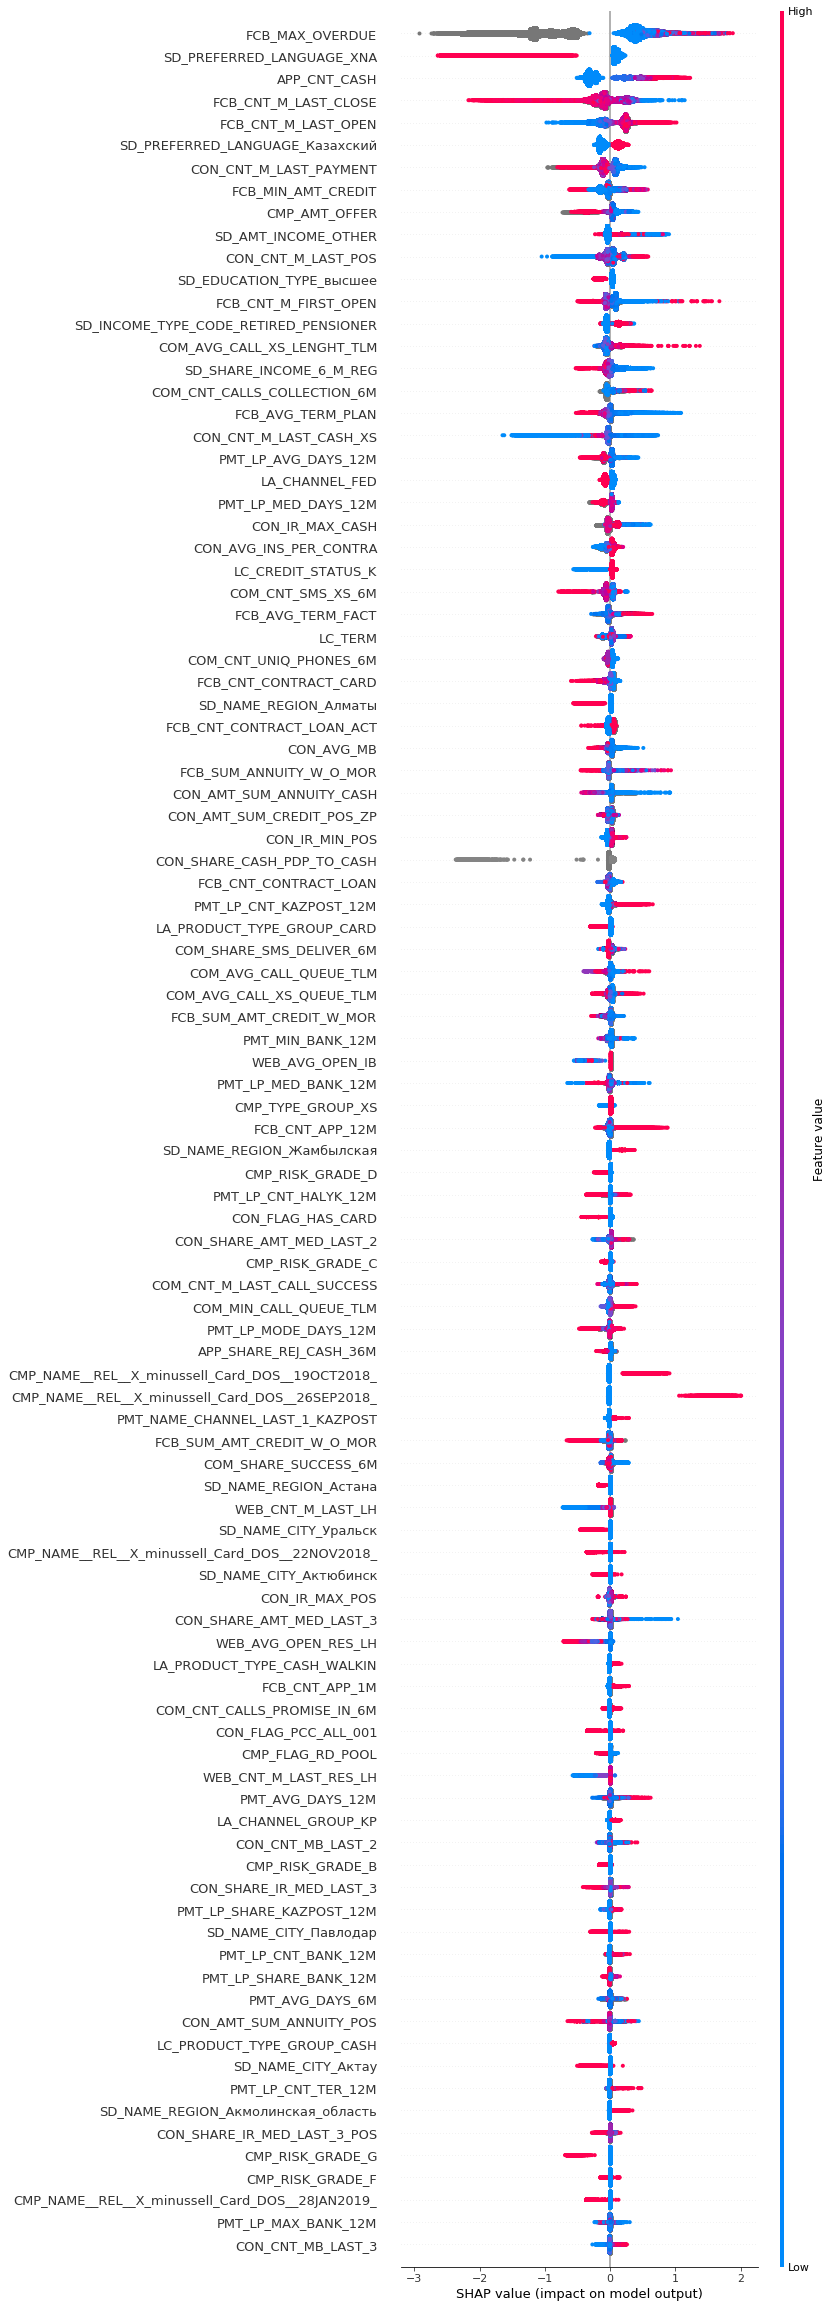

CPU times: user 9min 33s, sys: 17.8 s, total: 9min 51s
Wall time: 9min 30s


In [23]:
%%time
shap.summary_plot(shap_test,df_ncr,max_display=100, auto_size_plot=True)

In [24]:
import numpy as np
import sys
sys.path.append('/home/python/!Examples/Risk_Workflow/version6/scoring')
import feature_selection as fs

In [25]:
a=fs.get_shap_feature_importance(features_name,shap_test)
a_100=a[:100]

In [26]:
df1=df_ncr
df1['FLAG_APPLICATION']=target

In [26]:
%%time
b=fs.xgb_feature_selection(df=df1,col_target='FLAG_APPLICATION',fi_columns=a_100,params={'eval_metric':'auc','early_stopping_rounds':50,'verbose':False})

  0%|          | 0/100 [00:00<?, ?it/s]

[18:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[18:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[18:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[18:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[18:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[18:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[18:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[18:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[18:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

  1%|          | 1/100 [00:02<04:18,  2.61s/it]

[18:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[18:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[18:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[18:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[18:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[18:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[18:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[18:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[18:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_

  2%|▏         | 2/100 [00:05<04:21,  2.67s/it]

[18:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[18:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[18:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[18:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[18:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[18:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[18:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[18:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_

  3%|▎         | 3/100 [00:08<04:30,  2.79s/it]

[18:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[18:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, ma

[18:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[18:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[18:41:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[18:41:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[18:41:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:41:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:41:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:41:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, ma

  4%|▍         | 4/100 [00:14<05:56,  3.71s/it]

[18:41:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[18:41:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[18:41:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:41:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes,

[18:41:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[18:41:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:41:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:41:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:41:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[18:41:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:41:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:41:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[18:41:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, ma

[18:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[18:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[18:41:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6


  5%|▌         | 5/100 [00:24<08:55,  5.64s/it]

[18:41:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned no

[18:41:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:41:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:41:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:41:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:41:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:41:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:41:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:41:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:41:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, m

  6%|▌         | 6/100 [00:33<10:22,  6.62s/it]

[18:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned no

[18:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[18:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[18:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[18:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, m

  7%|▋         | 7/100 [00:43<11:46,  7.59s/it]

[18:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:41:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:41:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:41:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:41:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:41:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:41:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned no

[18:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[18:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[18:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[18:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, 

[18:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:41:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[18:41:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[18:41:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes,

  8%|▊         | 8/100 [00:54<13:22,  8.72s/it]

[18:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned no

[18:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[18:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[18:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[18:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[18:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, 

[18:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[18:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[18:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6


  9%|▉         | 9/100 [01:05<14:13,  9.38s/it]

[18:41:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[18:41:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nod

[18:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned node

[18:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[18:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[18:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes,

 10%|█         | 10/100 [01:18<15:28, 10.32s/it]

[18:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned no

[18:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[18:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[18:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes,

[18:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[18:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, 

 11%|█         | 11/100 [01:30<16:28, 11.11s/it]

[18:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned no

[18:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[18:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes

[18:42:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:42:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[18:42:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[18:42:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6


 12%|█▏        | 12/100 [01:43<16:49, 11.47s/it]

[18:42:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned no

[18:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[18:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned node

[18:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[18:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, 

 13%|█▎        | 13/100 [01:56<17:29, 12.06s/it]

[18:42:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:42:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[18:42:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:42:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:42:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:42:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:42:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:42:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:42:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes

[18:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned node

[18:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[18:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[18:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[18:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[18:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, 

 14%|█▍        | 14/100 [02:10<17:55, 12.51s/it]

[18:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned no

[18:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[18:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nod

[18:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[18:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[18:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes

 15%|█▌        | 15/100 [02:27<19:50, 14.01s/it]

[18:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[18:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:43:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:43:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:43:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:43:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:43:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:43:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned node

[18:43:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nod

[18:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[18:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[18:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[18:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, m

[18:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[18:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[18:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6


 16%|█▌        | 16/100 [02:48<22:22, 15.99s/it]

[18:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:43:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[18:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nod

[18:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[18:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[18:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes,

[18:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[18:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[18:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[18:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes,

 17%|█▋        | 17/100 [03:08<23:50, 17.23s/it]

[18:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[18:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned node

[18:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[18:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, m

 18%|█▊        | 18/100 [03:29<25:05, 18.37s/it]

[18:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[18:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned no

[18:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[18:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, 

 19%|█▉        | 19/100 [03:52<26:27, 19.60s/it]

[18:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:44:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:44:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nod

[18:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes

[18:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[18:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[18:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[18:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, 

 20%|██        | 20/100 [04:16<27:57, 20.97s/it]

[18:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[18:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[18:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned node

[18:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nod

[18:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[18:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[18:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[18:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes,

 21%|██        | 21/100 [04:36<27:16, 20.71s/it]

[18:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[18:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nod

[18:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[18:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes

 22%|██▏       | 22/100 [05:00<28:13, 21.71s/it]

[18:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned no

[18:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned no

[18:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[18:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[18:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, 

 23%|██▎       | 23/100 [05:23<28:21, 22.10s/it]

[18:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[18:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nod

[18:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes

[18:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[18:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[18:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6


 24%|██▍       | 24/100 [05:52<30:41, 24.23s/it]

[18:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[18:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[18:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nod

[18:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[18:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[18:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes,

[18:47:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:47:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:47:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:47:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[18:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[18:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes,

 25%|██▌       | 25/100 [06:21<32:10, 25.74s/it]

[18:47:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[18:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:47:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:47:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:47:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:47:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:47:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:47:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned no

[18:47:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:47:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[18:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned node

 26%|██▌       | 26/100 [06:48<32:14, 26.14s/it]

[18:47:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:47:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:47:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[18:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:47:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:47:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned no

[18:48:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:48:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:48:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:48:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[18:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned node

 27%|██▋       | 27/100 [07:15<31:52, 26.20s/it]

[18:48:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[18:48:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[18:48:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:48:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:48:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:48:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:48:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:48:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:48:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned node

[18:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:48:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nod

[18:48:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[18:48:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[18:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes,

 28%|██▊       | 28/100 [07:41<31:20, 26.11s/it]

[18:48:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:48:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:48:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:48:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:48:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:48:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:48:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:48:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:48:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[18:48:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:48:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:48:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:48:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:48:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:48:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned no

[18:48:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[18:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes

 29%|██▉       | 29/100 [08:09<31:48, 26.88s/it]

[18:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[18:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:49:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:49:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:49:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:49:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:49:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:49:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nod

[18:49:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:49:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:49:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[18:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[18:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:49:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes

 30%|███       | 30/100 [08:48<35:32, 30.46s/it]

[18:49:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[18:49:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:49:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:49:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:49:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:49:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:49:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:49:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:49:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[18:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nod

[18:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[18:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[18:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[18:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:50:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:50:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:50:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes,

 31%|███       | 31/100 [09:19<35:13, 30.63s/it]

[18:50:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:50:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:50:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:50:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:50:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:50:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:50:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:50:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:50:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned node

[18:50:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:50:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:50:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:50:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:50:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:50:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:50:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:50:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:50:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned no

[18:50:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:50:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:50:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[18:50:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:50:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:50:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:50:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:50:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:50:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes

 32%|███▏      | 32/100 [09:52<35:22, 31.21s/it]

[18:50:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:50:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:50:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:50:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:50:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:50:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:50:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:50:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:50:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[18:50:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:50:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:50:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:50:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:50:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:50:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:50:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:50:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:50:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nod

[18:51:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:51:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[18:51:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[18:51:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[18:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[18:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, m

[18:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[18:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:51:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[18:51:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:51:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes,

 33%|███▎      | 33/100 [10:31<37:26, 33.52s/it]

[18:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:51:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:51:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:51:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:51:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:51:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:51:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:51:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:51:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[18:51:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:51:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:51:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:51:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[18:51:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:51:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:51:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:51:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:51:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned node

[18:51:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[18:51:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[18:51:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:51:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[18:51:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:51:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:51:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[18:51:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:51:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, 

[18:51:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:51:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6


 34%|███▍      | 34/100 [11:02<36:18, 33.01s/it]

[18:51:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:51:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:51:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:51:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:51:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:51:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:51:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:51:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:51:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[18:52:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:52:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:52:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:52:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:52:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:52:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:52:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:52:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:52:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned no

[18:52:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:52:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:52:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:52:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[18:52:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:52:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:52:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:52:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:52:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes,

 35%|███▌      | 35/100 [11:33<34:59, 32.30s/it]

[18:52:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:52:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:52:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:52:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:52:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:52:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:52:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:52:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:52:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[18:52:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:52:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:52:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:52:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:52:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:52:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:52:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:52:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:52:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nod

[18:52:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:52:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:52:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[18:52:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:52:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:52:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:52:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:52:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[18:52:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes

[18:52:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[18:52:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[18:52:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:52:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[18:52:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:52:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:52:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:52:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:52:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max

 36%|███▌      | 36/100 [12:06<34:46, 32.60s/it]

[18:52:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:52:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:53:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:53:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:53:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:53:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:53:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:53:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:53:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nod

[18:53:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:53:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:53:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:53:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:53:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:53:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:53:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:53:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:53:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned no

[18:53:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:53:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:53:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:53:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:53:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[18:53:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[18:53:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[18:53:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:53:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes,

[18:53:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[18:53:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[18:53:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[18:53:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:53:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:53:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:53:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[18:53:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[18:53:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max

 37%|███▋      | 37/100 [12:46<36:31, 34.78s/it]

[18:53:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[18:53:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:53:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:53:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:53:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:53:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:53:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:53:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:53:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[18:53:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:53:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:53:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:53:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:53:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:53:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:53:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:53:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[18:53:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned node

[18:54:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:54:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:54:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:54:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:54:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:54:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[18:54:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[18:54:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:54:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes,

 38%|███▊      | 38/100 [13:19<35:10, 34.04s/it]

[18:54:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[18:54:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:54:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:54:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:54:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:54:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:54:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:54:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:54:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nod

[18:54:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:54:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:54:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:54:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:54:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:54:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:54:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[18:54:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:54:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned node

[18:54:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:54:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:54:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:54:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:54:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:54:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[18:54:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[18:54:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[18:54:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes,

[18:54:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:54:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:54:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:54:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[18:54:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6


 39%|███▉      | 39/100 [13:53<34:47, 34.22s/it]

[18:54:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:54:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:54:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:54:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:54:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:54:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:54:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:54:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:54:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[18:55:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:55:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:55:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:55:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:55:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:55:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:55:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:55:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:55:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned node

[18:55:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:55:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[18:55:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:55:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:55:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:55:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes

 40%|████      | 40/100 [14:28<34:30, 34.51s/it]

[18:55:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[18:55:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:55:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:55:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:55:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:55:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:55:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:55:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:55:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[18:55:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:55:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:55:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:55:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:55:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:55:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:55:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:55:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:55:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nod

[18:55:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[18:55:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:55:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:55:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:55:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:55:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:55:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:55:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:55:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes

[18:56:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:56:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:56:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[18:56:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[18:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, 

 41%|████      | 41/100 [15:11<36:12, 36.83s/it]

[18:56:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:56:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:56:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:56:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:56:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:56:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:56:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:56:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:56:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[18:56:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:56:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:56:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:56:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:56:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:56:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:56:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:56:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:56:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned no

[18:56:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:56:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:56:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:56:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:56:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:56:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:56:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[18:56:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[18:56:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes

 42%|████▏     | 42/100 [15:44<34:38, 35.83s/it]

[18:56:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:56:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:56:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:56:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:56:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:56:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:56:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:56:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:56:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned no

[18:56:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:56:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:56:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:56:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:56:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:56:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:56:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:56:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:56:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned node

[18:57:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:57:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:57:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:57:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:57:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[18:57:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[18:57:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:57:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[18:57:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes,

 43%|████▎     | 43/100 [16:17<33:17, 35.04s/it]

[18:57:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:57:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[18:57:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:57:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:57:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:57:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:57:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:57:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:57:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[18:57:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:57:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[18:57:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:57:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:57:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:57:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:57:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:57:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:57:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned node

[18:57:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:57:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:57:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:57:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:57:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:57:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:57:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:57:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:57:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes

[18:57:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:57:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:57:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:57:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:57:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:57:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:57:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[18:57:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[18:57:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, 

 44%|████▍     | 44/100 [17:01<35:02, 37.55s/it]

[18:57:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[18:57:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:57:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:57:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:57:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:57:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:57:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:57:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:57:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nod

[18:58:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[18:58:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:58:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:58:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:58:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:58:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:58:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:58:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:58:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes

[18:58:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[18:58:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[18:58:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:58:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:58:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:58:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:58:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[18:58:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[18:58:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, 

[18:58:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:58:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:58:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:58:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:58:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6


 45%|████▌     | 45/100 [17:42<35:22, 38.59s/it]

[18:58:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nod

[18:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned node

[18:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:59:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned node

 46%|████▌     | 46/100 [18:23<35:32, 39.50s/it]

[18:59:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:59:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:59:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:59:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:59:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:59:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[18:59:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:59:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes

[18:59:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:59:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:59:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:59:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:59:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[18:59:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:59:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:59:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:59:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes

 47%|████▋     | 47/100 [19:04<35:06, 39.75s/it]

[18:59:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:59:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[18:59:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:59:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:59:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:59:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:59:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:00:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:00:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned node

[19:00:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:00:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:00:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:00:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:00:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:00:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:00:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:00:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:00:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nod

[19:00:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:00:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:00:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:00:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:00:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:00:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:00:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:00:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:00:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned node

[19:00:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:00:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:00:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:00:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[19:00:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:00:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:00:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:00:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:00:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes,

 48%|████▊     | 48/100 [19:58<38:12, 44.08s/it]

[19:00:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:00:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:00:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:00:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:00:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:00:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:00:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:00:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:00:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:01:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:01:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:01:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:01:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:01:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:01:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:01:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:01:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:01:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned node

[19:01:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:01:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:01:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:01:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:01:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:01:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:01:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:01:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:01:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes,

[19:01:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[19:01:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:01:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[19:01:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:01:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[19:01:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[19:01:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[19:01:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:01:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, ma

 49%|████▉     | 49/100 [20:47<38:48, 45.65s/it]

[19:01:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:01:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:01:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:01:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:01:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:01:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:01:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:01:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:01:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:01:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:01:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:01:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:01:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:01:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:01:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[19:01:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:01:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:01:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes,

[19:02:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:02:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[19:02:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[19:02:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:02:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:02:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:02:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:02:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:02:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, 

[19:02:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:02:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:02:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:02:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:02:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:02:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:02:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:02:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:02:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes

 50%|█████     | 50/100 [21:28<36:55, 44.31s/it]

[19:02:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:02:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:02:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:02:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:02:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:02:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:02:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:02:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:02:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:02:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:02:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:02:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:02:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:02:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:02:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:02:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:02:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:02:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes

[19:02:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:02:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:02:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:02:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:02:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[19:02:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:02:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[19:02:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:02:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes

 51%|█████     | 51/100 [22:03<33:50, 41.45s/it]

[19:02:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:02:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:03:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:03:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:03:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned no

[19:03:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:03:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:03:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:03:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:03:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:03:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:03:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:03:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:03:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned no

[19:03:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:03:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:03:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:03:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:03:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:03:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:03:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:03:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:03:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nod

[19:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[19:03:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nod

 52%|█████▏    | 52/100 [22:44<33:04, 41.35s/it]

[19:03:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:03:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:03:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:03:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:03:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:03:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:03:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:03:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:03:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned no

[19:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nod

[19:04:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:04:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:04:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[19:04:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[19:04:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:04:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:04:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:04:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:04:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, 

[19:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[19:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[19:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[19:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[19:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes,

 53%|█████▎    | 53/100 [23:28<32:52, 41.96s/it]

[19:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:04:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:04:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:04:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:04:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:04:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:04:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:04:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:04:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:04:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:04:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:04:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:04:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:04:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:04:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:04:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nod

[19:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[19:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[19:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:04:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes

[19:05:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[19:05:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:05:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:05:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[19:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[19:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, 

 54%|█████▍    | 54/100 [24:13<33:00, 43.06s/it]

[19:05:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:05:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:05:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:05:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:05:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:05:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:05:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:05:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned node

[19:05:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:05:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:05:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes

[19:05:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[19:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[19:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6


 55%|█████▌    | 55/100 [24:54<31:42, 42.27s/it]

[19:05:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:05:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:05:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:05:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:05:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:05:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:05:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:05:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:05:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned no

[19:06:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes

[19:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:06:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:06:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:06:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:06:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:06:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned node

 56%|█████▌    | 56/100 [25:32<30:13, 41.22s/it]

[19:06:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned no

[19:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:06:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:06:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:06:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:06:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nod

[19:06:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:06:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:06:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:06:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nod

[19:07:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:07:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[19:07:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:07:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6


 57%|█████▋    | 57/100 [26:14<29:37, 41.33s/it]

[19:07:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:07:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned node

[19:07:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:07:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:07:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:07:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:07:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes,

[19:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[19:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[19:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes,

 58%|█████▊    | 58/100 [26:59<29:42, 42.44s/it]

[19:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:07:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:07:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:07:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:07:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:08:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:08:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned node

[19:08:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[19:08:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:08:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:08:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:08:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:08:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:08:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:08:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[19:08:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes,

 59%|█████▉    | 59/100 [27:39<28:29, 41.70s/it]

[19:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:08:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:08:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:08:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:08:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:08:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:08:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:08:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:08:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:08:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:08:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:08:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:08:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nod

[19:09:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[19:09:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:09:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:09:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:09:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:09:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[19:09:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:09:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:09:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, 

[19:09:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:09:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:09:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:09:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[19:09:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:09:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:09:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:09:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:09:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes

 60%|██████    | 60/100 [28:30<29:44, 44.61s/it]

[19:09:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:09:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:09:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:09:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:09:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:09:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:09:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:09:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:09:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:09:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:09:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:09:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:09:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:09:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:09:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:09:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:09:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:09:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nod

[19:09:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:09:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:09:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:09:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:09:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[19:09:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[19:09:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[19:09:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[19:09:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, 

[19:10:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:10:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:10:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:10:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:10:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:10:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[19:10:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:10:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:10:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, 

 61%|██████    | 61/100 [29:21<30:06, 46.33s/it]

[19:10:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:10:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:10:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:10:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:10:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:10:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:10:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:10:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:10:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned no

[19:10:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:10:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:10:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:10:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:10:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:10:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:10:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:10:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:10:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nod

[19:10:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:10:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:10:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:10:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:10:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:10:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:10:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:10:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:10:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nod

[19:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6


 62%|██████▏   | 62/100 [30:02<28:23, 44.83s/it]

[19:10:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:10:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:10:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:10:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:10:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[19:11:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:11:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:11:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:11:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:11:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:11:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:11:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[19:11:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:11:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, 

[19:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[19:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[19:11:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, m

[19:11:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[19:11:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[19:11:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[19:11:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[19:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[19:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, m

 63%|██████▎   | 63/100 [30:57<29:27, 47.77s/it]

[19:11:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:11:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:11:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:11:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:11:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:11:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:11:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:11:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:11:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:12:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:12:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:12:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:12:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:12:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:12:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:12:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:12:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:12:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:12:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[19:12:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[19:12:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:12:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:12:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[19:12:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[19:12:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[19:12:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:12:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, m

[19:12:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:12:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:12:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:12:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:12:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:12:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[19:12:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[19:12:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:12:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes,

 64%|██████▍   | 64/100 [31:41<28:05, 46.83s/it]

[19:12:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:12:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:12:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:12:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:12:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:12:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:12:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:12:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:12:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:12:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:12:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:12:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:12:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:12:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:12:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:12:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:12:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:12:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned node

[19:13:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:13:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:13:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[19:13:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:13:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:13:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:13:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[19:13:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[19:13:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes,

[19:13:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[19:13:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:13:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:13:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:13:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[19:13:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:13:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[19:13:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:13:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, 

 65%|██████▌   | 65/100 [32:27<27:09, 46.55s/it]

[19:13:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:13:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:13:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:13:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:13:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:13:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:13:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:13:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:13:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:13:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:13:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:13:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:13:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[19:13:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:13:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:13:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:13:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:13:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned node

[19:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[19:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned node

 66%|██████▌   | 66/100 [33:09<25:32, 45.06s/it]

[19:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned no

[19:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned node

[19:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[19:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[19:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned node

 67%|██████▋   | 67/100 [33:52<24:24, 44.38s/it]

[19:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:15:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:15:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:15:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:15:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned node

[19:15:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:15:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:15:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[19:15:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[19:15:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[19:15:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:15:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:15:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:15:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, 

[19:15:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:15:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[19:15:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:15:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:15:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:15:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:15:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[19:15:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:15:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, m

 68%|██████▊   | 68/100 [34:40<24:16, 45.52s/it]

[19:15:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:15:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:15:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:15:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:15:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:15:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:15:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:15:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:15:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:15:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:15:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:15:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:15:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:15:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned no

[19:16:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:16:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:16:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:16:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:16:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:16:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:16:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[19:16:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:16:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes

[19:16:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[19:16:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:16:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:16:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:16:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[19:16:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:16:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[19:16:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[19:16:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, ma

 69%|██████▉   | 69/100 [35:29<24:03, 46.56s/it]

[19:16:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:16:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:16:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:16:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:16:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:16:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:16:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:16:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:16:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:16:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:16:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:16:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:16:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:16:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:16:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:16:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:16:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:16:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nod

[19:16:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[19:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[19:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[19:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:16:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:16:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes,

[19:17:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:17:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[19:17:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:17:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:17:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[19:17:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[19:17:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:17:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:17:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes

 70%|███████   | 70/100 [36:20<23:58, 47.95s/it]

[19:17:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[19:17:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:17:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:17:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:17:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:17:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:17:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:17:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:17:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[19:17:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:17:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:17:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:17:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:17:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:17:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:17:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:17:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:17:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned node

[19:17:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:17:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:17:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:17:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:17:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:17:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:17:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:17:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:17:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned node

[19:18:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[19:18:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:18:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:18:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[19:18:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:18:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:18:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:18:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[19:18:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max

 71%|███████   | 71/100 [37:10<23:31, 48.68s/it]

[19:18:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:18:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:18:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:18:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:18:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:18:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:18:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:18:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:18:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:18:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:18:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:18:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:18:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:18:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:18:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:18:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:18:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:18:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nod

[19:18:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[19:18:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:18:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:18:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:18:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[19:18:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:18:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:18:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[19:18:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes

[19:18:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:18:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[19:18:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:18:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6


 72%|███████▏  | 72/100 [37:56<22:18, 47.79s/it]

[19:18:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:18:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:18:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:18:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:18:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:18:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:18:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:18:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:18:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:19:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:19:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:19:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:19:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:19:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:19:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:19:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:19:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:19:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned no

[19:19:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:19:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:19:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[19:19:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:19:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:19:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:19:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:19:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:19:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes

 73%|███████▎  | 73/100 [38:42<21:15, 47.22s/it]

[19:19:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:19:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:19:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:19:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:19:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:19:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:19:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:19:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:19:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:19:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:19:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:19:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:19:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:19:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:19:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes

[19:20:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:20:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:20:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:20:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:20:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:20:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:20:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[19:20:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:20:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned node

 74%|███████▍  | 74/100 [39:28<20:14, 46.72s/it]

[19:20:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:20:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:20:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:20:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:20:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:20:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:20:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:20:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:20:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned no

[19:20:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:20:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:20:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:20:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:20:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:20:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:20:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:20:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:20:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[19:20:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:20:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:20:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[19:20:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:20:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:20:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:20:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:20:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[19:20:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes

[19:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:21:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:21:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:21:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:21:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:21:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[19:21:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, 

 75%|███████▌  | 75/100 [40:21<20:21, 48.87s/it]

[19:21:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:21:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:21:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:21:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:21:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:21:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:21:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:21:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:21:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nod

[19:21:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:21:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:21:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:21:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:21:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:21:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:21:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:21:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:21:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nod

[19:21:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:21:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:21:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:21:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:21:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:21:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:21:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:21:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[19:21:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned node

[19:22:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:22:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[19:22:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:22:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[19:22:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:22:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:22:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:22:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[19:22:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes,

 76%|███████▌  | 76/100 [41:13<19:54, 49.75s/it]

[19:22:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:22:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:22:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:22:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:22:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:22:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:22:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:22:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:22:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[19:22:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:22:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:22:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:22:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:22:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:22:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:22:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:22:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:22:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes,

[19:22:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:22:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:22:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:22:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes

 77%|███████▋  | 77/100 [42:00<18:45, 48.95s/it]

[19:22:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:22:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:22:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:22:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:22:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned node

[19:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[19:23:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:23:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:23:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes

[19:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[19:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[19:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes

 78%|███████▊  | 78/100 [42:59<18:57, 51.72s/it]

[19:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned no

[19:24:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:24:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:24:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[19:24:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:24:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[19:24:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:24:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:24:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:24:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes,

[19:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6


 79%|███████▉  | 79/100 [43:49<18:00, 51.47s/it]

[19:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:24:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:24:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:24:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:24:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[19:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:25:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nod

[19:25:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:25:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[19:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[19:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:25:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes

[19:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[19:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[19:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes

 80%|████████  | 80/100 [44:46<17:39, 52.98s/it]

[19:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:25:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:25:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:25:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:25:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:25:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:25:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:25:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes

[19:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned node

[19:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[19:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[19:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes,

 81%|████████  | 81/100 [45:50<17:47, 56.20s/it]

[19:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[19:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:27:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:27:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:27:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:27:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:27:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:27:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nod

[19:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:27:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes

[19:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[19:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[19:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, 

 82%|████████▏ | 82/100 [46:49<17:07, 57.09s/it]

[19:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:27:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nod

[19:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:28:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[19:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[19:28:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes,

[19:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[19:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes

 83%|████████▎ | 83/100 [47:47<16:16, 57.45s/it]

[19:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[19:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[19:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned node

[19:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:29:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:29:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:29:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nod

[19:29:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:29:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:29:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:29:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:29:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:29:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[19:29:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:29:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes

 84%|████████▍ | 84/100 [48:56<16:12, 60.77s/it]

[19:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[19:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[19:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned node

[19:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:30:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes,

[19:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[19:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes,

 85%|████████▌ | 85/100 [50:01<15:33, 62.21s/it]

[19:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:31:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned node

[19:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[19:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned node

[19:31:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:31:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[19:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[19:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:31:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:31:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes,

 86%|████████▌ | 86/100 [51:09<14:54, 63.90s/it]

[19:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[19:32:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:32:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[19:32:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:32:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:32:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:32:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:32:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:32:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned node

[19:32:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:32:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:32:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:32:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:32:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:32:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:32:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:32:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:32:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes,

[19:33:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6


 87%|████████▋ | 87/100 [52:09<13:35, 62.74s/it]

[19:33:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:33:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:33:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:33:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:33:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:33:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:33:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:33:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:33:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:33:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:33:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:33:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:33:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:33:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:33:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:33:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:33:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:33:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nod

[19:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[19:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[19:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, m

[19:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[19:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[19:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[19:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:34:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, m

 88%|████████▊ | 88/100 [53:18<12:54, 64.50s/it]

[19:34:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[19:34:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:34:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:34:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:34:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:34:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:34:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:34:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:34:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[19:34:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:34:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:34:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:34:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:34:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:34:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:34:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:34:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:34:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nod

[19:34:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:34:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:34:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[19:34:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:34:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:34:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:34:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:34:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:34:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned node

 89%|████████▉ | 89/100 [54:21<11:46, 64.23s/it]

[19:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:35:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:35:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:35:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:35:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:35:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:35:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:35:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:35:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned no

[19:35:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:35:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:35:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:35:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:35:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:35:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:35:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:35:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:35:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned no

[19:35:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:35:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:35:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:35:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:36:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:36:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:36:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:36:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:36:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nod

[19:36:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:36:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[19:36:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[19:36:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:36:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:36:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:36:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:36:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[19:36:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes,

 90%|█████████ | 90/100 [55:30<10:54, 65.48s/it]

[19:36:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:36:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:36:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:36:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:36:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:36:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:36:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:36:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:36:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned no

[19:36:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:36:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:36:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:36:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:36:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:36:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:36:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:36:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[19:36:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes,

[19:37:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:37:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:37:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:37:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:37:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[19:37:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:37:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:37:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:37:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, m

[19:37:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:37:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:37:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[19:37:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:37:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:37:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:37:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:37:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[19:37:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes,

 91%|█████████ | 91/100 [56:38<09:57, 66.35s/it]

[19:37:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:37:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:37:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:37:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:37:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:37:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:37:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:37:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:37:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[19:37:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:37:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:37:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:37:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:37:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:37:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:37:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[19:37:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:37:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes

[19:38:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[19:38:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:38:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:38:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:38:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:38:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:38:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[19:38:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:38:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes

[19:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[19:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:38:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:38:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, 

 92%|█████████▏| 92/100 [57:41<08:42, 65.34s/it]

[19:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:38:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:38:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:38:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:38:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nod

[19:39:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:39:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:39:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[19:39:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:39:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, 

[19:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[19:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:39:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[19:39:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[19:39:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:39:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:39:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, 

 93%|█████████▎| 93/100 [58:44<07:32, 64.71s/it]

[19:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:39:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nod

[19:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:39:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:39:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:39:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:39:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:40:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nod

[19:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[19:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned node

[19:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[19:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[19:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes

 94%|█████████▍| 94/100 [59:53<06:35, 65.94s/it]

[19:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned no

[19:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned node

[19:41:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:41:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:41:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:41:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[19:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes,

[19:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[19:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[19:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes,

 95%|█████████▌| 95/100 [1:00:53<05:20, 64.15s/it]

[19:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:41:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:41:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:41:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:41:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:41:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned node

[19:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[19:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[19:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:42:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:42:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes

[19:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[19:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[19:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes,

 96%|█████████▌| 96/100 [1:01:54<04:13, 63.29s/it]

[19:42:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:42:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:42:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:42:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:42:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:42:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:42:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:43:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:43:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:43:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:43:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:43:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:43:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nod

[19:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[19:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[19:43:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes

[19:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[19:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[19:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[19:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[19:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[19:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, m

 97%|█████████▋| 97/100 [1:03:21<03:31, 70.44s/it]

[19:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[19:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[19:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes

[19:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[19:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[19:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes,

[19:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[19:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[19:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, 

 98%|█████████▊| 98/100 [1:04:35<02:22, 71.42s/it]

[19:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nod

[19:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[19:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[19:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes,

[19:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[19:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[19:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[19:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, m

[19:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[19:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[19:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes

 99%|█████████▉| 99/100 [1:05:38<01:08, 68.76s/it]

[19:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[19:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nod

[19:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:46:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:46:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:46:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned no

[19:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:47:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:47:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:47:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[19:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[19:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned node

[19:47:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6


100%|██████████| 100/100 [1:06:37<00:00, 65.83s/it]

[19:47:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
CPU times: user 7h 58min 50s, sys: 1min 30s, total: 8h 21s
Wall time: 1h 6min 37s


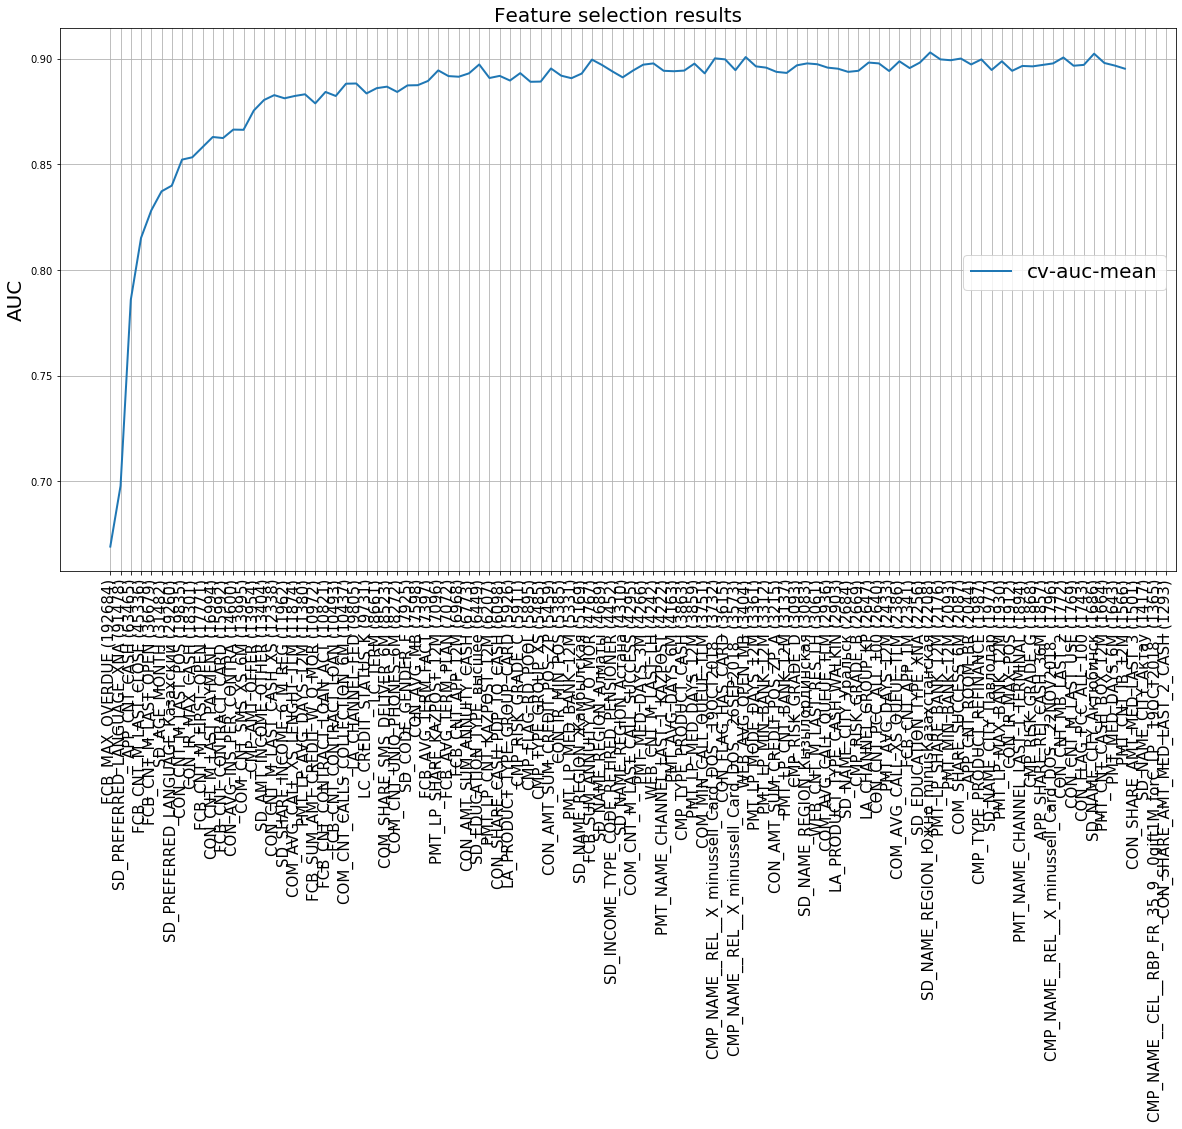

In [27]:
fs.plot_feature_selection(a,b)

In [27]:
pt=pd.DataFrame(a_100,columns=['Name_feature','shape_value'])

In [28]:
a_100

[('FCB_MAX_OVERDUE', 169625.11),
 ('SD_PREFERRED_LANGUAGE_XNA', 88272.62),
 ('APP_CNT_CASH', 67558.2),
 ('FCB_CNT_M_LAST_CLOSE', 54248.16),
 ('FCB_CNT_M_LAST_OPEN', 38537.45),
 ('SD_PREFERRED_LANGUAGE_Казахский', 25865.5),
 ('CON_CNT_M_LAST_PAYMENT', 20770.07),
 ('FCB_MIN_AMT_CREDIT', 20585.23),
 ('CMP_AMT_OFFER', 19203.521),
 ('SD_AMT_INCOME_OTHER', 17459.963),
 ('CON_CNT_M_LAST_POS', 17367.643),
 ('SD_EDUCATION_TYPE_высшее', 14740.707),
 ('FCB_CNT_M_FIRST_OPEN', 14617.541),
 ('SD_INCOME_TYPE_CODE_RETIRED_PENSIONER', 14565.314),
 ('COM_AVG_CALL_XS_LENGHT_TLM', 13540.521),
 ('SD_SHARE_INCOME_6_M_REG', 12969.568),
 ('COM_CNT_CALLS_COLLECTION_6M', 12712.327),
 ('FCB_AVG_TERM_PLAN', 12566.641),
 ('CON_CNT_M_LAST_CASH_XS', 11848.794),
 ('PMT_LP_AVG_DAYS_12M', 11584.21),
 ('LA_CHANNEL_FED', 11409.108),
 ('PMT_LP_MED_DAYS_12M', 11322.15),
 ('CON_IR_MAX_CASH', 11315.506),
 ('CON_AVG_INS_PER_CONTRA', 11063.924),
 ('LC_CREDIT_STATUS_K', 10794.782),
 ('COM_CNT_SMS_XS_6M', 10608.163),
 ('FCB_AVG_TERM_FACT', 8962.1),
 ('LC_TERM', 8852.549),
 ('COM_CNT_UNIQ_PHONES_6M', 8491.801),
 ('FCB_CNT_CONTRACT_CARD', 8304.57),
 ('SD_NAME_REGION_Алматы', 7944.929),
 ('FCB_CNT_CONTRACT_LOAN_ACT', 7358.804),
 ('CON_AVG_MB', 6840.297),
 ('FCB_SUM_ANNUITY_W_O_MOR', 6552.1777),
 ('CON_AMT_SUM_ANNUITY_CASH', 6543.771),
 ('CON_AMT_SUM_CREDIT_POS_ZP', 6390.8506),
 ('CON_IR_MIN_POS', 6389.8726),
 ('CON_SHARE_CASH_PDP_TO_CASH', 6181.6562),
 ('FCB_CNT_CONTRACT_LOAN', 6061.7095),
 ('PMT_LP_CNT_KAZPOST_12M', 5970.396),
 ('LA_PRODUCT_TYPE_GROUP_CARD', 5480.3247),
 ('COM_SHARE_SMS_DELIVER_6M', 5415.166),
 ('COM_AVG_CALL_QUEUE_TLM', 5325.671),
 ('COM_AVG_CALL_XS_QUEUE_TLM', 5289.225),
 ('FCB_SUM_AMT_CREDIT_W_MOR', 5276.096),
 ('PMT_MIN_BANK_12M', 5163.2593),
 ('WEB_AVG_OPEN_IB', 5098.4067),
 ('PMT_LP_MED_BANK_12M', 4820.3657),
 ('CMP_TYPE_GROUP_XS', 4701.381),
 ('FCB_CNT_APP_12M', 4641.4126),
 ('SD_NAME_REGION_Жамбылская', 4612.7183),
 ('CMP_RISK_GRADE_D', 4326.1387),
 ('PMT_LP_CNT_HALYK_12M', 4205.5435),
 ('CON_FLAG_HAS_CARD', 4162.9106),
 ('CON_SHARE_AMT_MED_LAST_2', 4161.505),
 ('CMP_RISK_GRADE_C', 3912.1328),
 ('COM_CNT_M_LAST_CALL_SUCCESS', 3881.2488),
 ('COM_MIN_CALL_QUEUE_TLM', 3853.2705),
 ('PMT_LP_MODE_DAYS_12M', 3819.7698),
 ('APP_SHARE_REJ_CASH_36M', 3779.4722),
 ('CMP_NAME__REL__X_minussell_Card_DOS__19OCT2018_', 3747.9375),
 ('CMP_NAME__REL__X_minussell_Card_DOS__26SEP2018_', 3670.8264),
 ('PMT_NAME_CHANNEL_LAST_1_KAZPOST', 3637.8857),
 ('FCB_SUM_AMT_CREDIT_W_O_MOR', 3619.9155),
 ('COM_SHARE_SUCCESS_6M', 3520.6382),
 ('SD_NAME_REGION_Астана', 3267.6223),
 ('WEB_CNT_M_LAST_LH', 3041.072),
 ('SD_NAME_CITY_Уральск', 3009.568),
 ('CMP_NAME__REL__X_minussell_Card_DOS__22NOV2018_', 2807.1653),
 ('SD_NAME_CITY_Актюбинск', 2768.8572),
 ('CON_IR_MAX_POS', 2710.596),
 ('CON_SHARE_AMT_MED_LAST_3', 2646.0913),
 ('WEB_AVG_OPEN_RES_LH', 2645.6704),
 ('LA_PRODUCT_TYPE_CASH_WALKIN', 2624.3162),
 ('FCB_CNT_APP_1M', 2525.9756),
 ('COM_CNT_CALLS_PROMISE_IN_6M', 2481.5635),
 ('CON_FLAG_PCC_ALL_001', 2438.3909),
 ('CMP_FLAG_RD_POOL', 2350.2292),
 ('WEB_CNT_M_LAST_RES_LH', 2304.1719),
 ('PMT_AVG_DAYS_12M', 2274.8489),
 ('LA_CHANNEL_GROUP_KP', 2261.2324),
 ('CON_CNT_MB_LAST_2', 2248.829),
 ('CMP_RISK_GRADE_B', 2212.0151),
 ('CON_SHARE_IR_MED_LAST_3', 2147.5938),
 ('PMT_LP_SHARE_KAZPOST_12M', 2084.786),
 ('SD_NAME_CITY_Павлодар', 2012.8624),
 ('PMT_LP_CNT_BANK_12M', 2012.3721),
 ('PMT_LP_SHARE_BANK_12M', 1982.72),
 ('PMT_AVG_DAYS_6M', 1977.6387),
 ('CON_AMT_SUM_ANNUITY_POS', 1924.6238),
 ('LC_PRODUCT_TYPE_GROUP_CASH', 1895.6814),
 ('SD_NAME_CITY_Актау', 1826.852),
 ('PMT_LP_CNT_TER_12M', 1779.2119),
 ('SD_NAME_REGION_Акмолинская_область', 1768.2772),
 ('CON_SHARE_IR_MED_LAST_3_POS', 1741.8845),
 ('CMP_RISK_GRADE_G', 1735.309),
 ('CMP_RISK_GRADE_F', 1660.1847),
 ('CMP_NAME__REL__X_minussell_Card_DOS__28JAN2019_', 1633.8568),
 ('PMT_LP_MAX_BANK_12M', 1565.6237),
 ('CON_CNT_MB_LAST_3', 1538.6788)]

In [30]:
len(b[0][1:][0])

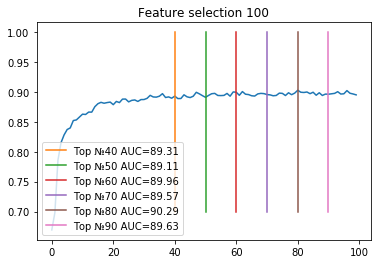

In [43]:
b1=b[0][1:][0]
import matplotlib.pyplot as plt
plt.plot(range(len(a_100)),b1)
top=40
plt.plot([top,top],[1,0.7],label='Top №'+str(top)+' AUC='+str(b1[top]*100))
top=50
plt.plot([top,top],[1,0.7],label='Top №'+str(top)+' AUC='+str(b1[top]*100))
top=60
plt.plot([top,top],[1,0.7],label='Top №'+str(top)+' AUC='+str(b1[top]*100))
top=70
plt.plot([top,top],[1,0.7],label='Top №'+str(top)+' AUC='+str(round(b1[top]*100,2)))
top=80
plt.plot([top,top],[1,0.7],label='Top №'+str(top)+' AUC='+str(b1[top]*100))
top=90
plt.plot([top,top],[1,0.7],label='Top №'+str(top)+' AUC='+str(b1[top]*100))
#top=100
#plt.plot([top,top],[1,0.7],label='Top №'+str(top)+' AUC='+str(b1[top]*100))
#top=110
#plt.plot([top,top],[1,0.7],label='Top №'+str(top)+' AUC='+str(b1[top]*100))
plt.title('Feature selection 100')

plt.legend(loc='best')
plt.show()

In [31]:
df_query.head(2)

SKP_CLIENT     MONTH_  SD_AGE SD_FLAG_PENSIONER SD_NAME_CITY  \
0          27 2018-12-01    64.9                 Y       Алматы   
1          29 2018-11-01    54.1                 N      Зеренда   

   SD_AMT_INCOME_MAIN  SD_AMT_INCOME_OTHER SD_PREFERRED_LANGUAGE  \
0            100000.0                  0.0               Русский   
1            150000.0                  0.0               Русский   

   SD_AGE_MONTH SD_CODE_GENDER       ...        FCB_CNT_CONTRACT_CAR  \
0        778.45              F       ...                         NaN   
1        649.55              M       ...                         NaN   

  FCB_CNT_CONTRACT_MOR  FCB_CNT_CONTRACT_BIZ FCB_CNT_CONTRACT_ACT  \
0                  NaN                   NaN                  NaN   
1                  NaN                   NaN                  NaN   

  FCB_CNT_CONTRACT_LOAN_ACT FCB_CNT_CONTRACT_CARD_ACT  \
0                       NaN                       NaN   
1                       NaN                       NaN   

  FCB_CNT_CONTRACT_CAR_ACT  FCB_CNT_CONTRACT_MOR_ACT FCB_CNT_CONTRACT_BIZ_ACT  \
0                      NaN                       NaN                      NaN   
1                      NaN                       NaN                      NaN   

  FLAG_APPLICATION  
0                1  
1                1  

[2 rows x 599 columns]

In [32]:
cat_feat_objects = df_query.columns[df_query.dtypes=='object']
cat_feat_objects

Index(['SD_FLAG_PENSIONER', 'SD_NAME_CITY', 'SD_PREFERRED_LANGUAGE',
       'SD_CODE_GENDER', 'SD_INCOME_TYPE_CODE', 'SD_INCOME_TYPE',
       'SD_EDUCATION_TYPE', 'SD_CODE_FAMILY_STATUS', 'SD_NAME_HOUSING_TYPE',
       'SD_NAME_REGION', 'CMP_TYPE_GROUP', 'CMP_TYPE_PRODUCT',
       'CMP_RISK_GRADE', 'CMP_NAME', 'LA_CREDIT_STATUS',
       'LA_CREDIT_STATUS_GROUP', 'LA_NUMBER_OF_GIFT', 'LA_RATE_INTEREST_CARD',
       'LA_PRODUCT_TYPE', 'LA_PRODUCT_TYPE_GROUP', 'LA_CHANNEL',
       'LA_CHANNEL_GROUP', 'LA_CHANNEL_POS', 'LA_NAME_GOODS_CATEGORY',
       'LC_RATE_INTEREST_CARD', 'LC_PRODUCT_TYPE_GROUP', 'LC_PRODUCT_TYPE',
       'LC_CREDIT_STATUS', 'LC_CREDIT_STATUS_GROUP', 'LC_NAME_GOODS_CATEGORY',
       'LC_CHANNEL', 'LC_CHANNEL_GROUP', 'LC_CHANNEL_POS', 'LC_NUMBER_OF_GIFT',
       'CON_AMT_PAY_INTEREST_ALL', 'CON_AMT_PAY_INTEREST_POS',
       'CON_AMT_PAY_INTEREST_CASH', 'CON_AMT_PAY_INTEREST_CARD',
       'CON_CNT_PCC_ALL', 'CON_FLAG_PCC_ALL', 'CON_CNT_PCC_ALL_A',
       'CON_FLAG_PCC_AL

In [33]:
caget_dumm=dict()
for k in cat_feat_objects:
    r1=list(map(lambda b: b.replace("-","_minus"), pd.get_dummies(df_query[k]).columns.tolist()))
    r2=list(map(lambda b: b.replace("+","_plus"), r1))
    r3=list(map(lambda b: re.sub(r"[\W ]", '_', b), r2))
    for i in r3:
        caget_dumm[k+'_'+i]=k
     

In [34]:
def top_features(n):
    top=pt.Name_feature.head(n).tolist()
    all_columns=df_query.columns.tolist()
    tf=[]
    for i in top:
        for j in all_columns:
            if (i==j):
                tf.append(i)
    tf=list(set(tf))
    for i in list(set().union(top)-set().union(tf)):
        tf.append(caget_dumm[i])
    tf=list(set(tf))
    return tf



In [35]:
top_features(100)

['CON_AMT_SUM_ANNUITY_POS',
 'COM_CNT_CALLS_PROMISE_IN_6M',
 'COM_AVG_CALL_QUEUE_TLM',
 'CON_IR_MIN_POS',
 'WEB_AVG_OPEN_IB',
 'CON_CNT_M_LAST_PAYMENT',
 'CON_AMT_SUM_CREDIT_POS_ZP',
 'PMT_AVG_DAYS_6M',
 'SD_PREFERRED_LANGUAGE',
 'LA_CHANNEL_GROUP',
 'LC_PRODUCT_TYPE_GROUP',
 'PMT_LP_CNT_TER_12M',
 'FCB_CNT_APP_12M',
 'PMT_LP_MED_BANK_12M',
 'COM_SHARE_SUCCESS_6M',
 'FCB_MAX_OVERDUE',
 'CON_SHARE_IR_MED_LAST_3',
 'CMP_RISK_GRADE',
 'CON_CNT_MB_LAST_3',
 'CON_FLAG_HAS_CARD',
 'COM_CNT_M_LAST_CALL_SUCCESS',
 'PMT_LP_MAX_BANK_12M',
 'CON_IR_MAX_CASH',
 'LA_PRODUCT_TYPE',
 'FCB_AVG_TERM_FACT',
 'CON_AVG_MB',
 'CON_CNT_MB_LAST_2',
 'SD_NAME_REGION',
 'SD_NAME_CITY',
 'FCB_CNT_M_LAST_OPEN',
 'FCB_AVG_TERM_PLAN',
 'SD_EDUCATION_TYPE',
 'PMT_LP_SHARE_BANK_12M',
 'PMT_LP_AVG_DAYS_12M',
 'PMT_LP_CNT_KAZPOST_12M',
 'COM_AVG_CALL_XS_LENGHT_TLM',
 'FCB_SUM_AMT_CREDIT_W_O_MOR',
 'PMT_MIN_BANK_12M',
 'LA_PRODUCT_TYPE_GROUP',
 'FCB_SUM_AMT_CREDIT_W_MOR',
 'PMT_LP_CNT_HALYK_12M',
 'SD_SHARE_INCOME_6_M_REG',
 'FCB_SUM_ANNUITY_W_O_MOR',
 'CON_SHARE_AMT_MED_LAST_3',
 'PMT_LP_SHARE_KAZPOST_12M',
 'PMT_NAME_CHANNEL_LAST_1',
 'CMP_AMT_OFFER',
 'COM_AVG_CALL_XS_QUEUE_TLM',
 'CMP_TYPE_GROUP',
 'FCB_MIN_AMT_CREDIT',
 'FCB_CNT_CONTRACT_CARD',
 'CON_AVG_INS_PER_CONTRA',
 'WEB_CNT_M_LAST_RES_LH',
 'SD_AMT_INCOME_OTHER',
 'FCB_CNT_APP_1M',
 'CON_SHARE_AMT_MED_LAST_2',
 'CMP_NAME',
 'WEB_CNT_M_LAST_LH',
 'FCB_CNT_CONTRACT_LOAN',
 'PMT_LP_MED_DAYS_12M',
 'CON_FLAG_PCC_ALL',
 'LC_TERM',
 'CON_IR_MAX_POS',
 'LC_CREDIT_STATUS',
 'APP_SHARE_REJ_CASH_36M',
 'PMT_LP_MODE_DAYS_12M',
 'FCB_CNT_M_FIRST_OPEN',
 'APP_CNT_CASH',
 'COM_SHARE_SMS_DELIVER_6M',
 'PMT_AVG_DAYS_12M',
 'CON_SHARE_CASH_PDP_TO_CASH',
 'FCB_CNT_M_LAST_CLOSE',
 'PMT_LP_CNT_BANK_12M',
 'COM_MIN_CALL_QUEUE_TLM',
 'LA_CHANNEL',
 'CON_AMT_SUM_ANNUITY_CASH',
 'WEB_AVG_OPEN_RES_LH',
 'COM_CNT_UNIQ_PHONES_6M',
 'FCB_CNT_CONTRACT_LOAN_ACT',
 'CON_SHARE_IR_MED_LAST_3_POS',
 'CON_CNT_M_LAST_CASH_XS',
 'SD_INCOME_TYPE_CODE',
 'CON_CNT_M_LAST_POS',
 'CMP_FLAG_RD_POOL',
 'COM_CNT_CALLS_COLLECTION_6M',
 'COM_CNT_SMS_XS_6M']

In [36]:
len(top_features(100))

86

In [37]:
list_RISK_GRADE=[s for s in top_features(100) if "RISK_GRADE" in s]
list_RISK_GRADE

['CMP_RISK_GRADE']

In [38]:
list_Language=[s for s in top_features(100) if "LANGUAGE" in s]
list_Language

['SD_PREFERRED_LANGUAGE']

In [39]:
list1=set().union(top_features(100))-set().union(list_RISK_GRADE)-set().union(list_Language)
len(list1)

84

In [40]:
list(list1)

['CON_AMT_SUM_ANNUITY_POS',
 'COM_CNT_CALLS_PROMISE_IN_6M',
 'COM_AVG_CALL_QUEUE_TLM',
 'CON_IR_MIN_POS',
 'PMT_MIN_BANK_12M',
 'WEB_AVG_OPEN_IB',
 'LA_PRODUCT_TYPE_GROUP',
 'FCB_SUM_AMT_CREDIT_W_MOR',
 'CON_CNT_M_LAST_PAYMENT',
 'PMT_LP_CNT_HALYK_12M',
 'SD_SHARE_INCOME_6_M_REG',
 'CON_AMT_SUM_CREDIT_POS_ZP',
 'FCB_SUM_ANNUITY_W_O_MOR',
 'PMT_AVG_DAYS_6M',
 'CON_SHARE_AMT_MED_LAST_3',
 'PMT_LP_SHARE_KAZPOST_12M',
 'PMT_NAME_CHANNEL_LAST_1',
 'LA_CHANNEL_GROUP',
 'CMP_AMT_OFFER',
 'COM_AVG_CALL_XS_QUEUE_TLM',
 'LC_PRODUCT_TYPE_GROUP',
 'CMP_TYPE_GROUP',
 'PMT_LP_CNT_TER_12M',
 'FCB_MIN_AMT_CREDIT',
 'FCB_CNT_CONTRACT_CARD',
 'CON_AVG_INS_PER_CONTRA',
 'WEB_CNT_M_LAST_RES_LH',
 'SD_AMT_INCOME_OTHER',
 'FCB_CNT_APP_12M',
 'FCB_CNT_APP_1M',
 'CON_SHARE_AMT_MED_LAST_2',
 'CMP_NAME',
 'PMT_LP_MED_BANK_12M',
 'WEB_CNT_M_LAST_LH',
 'COM_SHARE_SUCCESS_6M',
 'FCB_CNT_CONTRACT_LOAN',
 'FCB_MAX_OVERDUE',
 'CON_SHARE_IR_MED_LAST_3',
 'PMT_LP_MED_DAYS_12M',
 'CON_CNT_MB_LAST_3',
 'CON_FLAG_HAS_CARD',
 'CON_FLAG_PCC_ALL',
 'COM_CNT_M_LAST_CALL_SUCCESS',
 'PMT_LP_MAX_BANK_12M',
 'CON_IR_MAX_CASH',
 'LC_TERM',
 'CON_IR_MAX_POS',
 'LC_CREDIT_STATUS',
 'APP_SHARE_REJ_CASH_36M',
 'PMT_LP_MODE_DAYS_12M',
 'LA_PRODUCT_TYPE',
 'FCB_AVG_TERM_FACT',
 'FCB_CNT_M_FIRST_OPEN',
 'CON_AVG_MB',
 'APP_CNT_CASH',
 'CON_CNT_MB_LAST_2',
 'SD_NAME_REGION',
 'SD_NAME_CITY',
 'COM_SHARE_SMS_DELIVER_6M',
 'PMT_AVG_DAYS_12M',
 'FCB_CNT_M_LAST_OPEN',
 'CON_SHARE_CASH_PDP_TO_CASH',
 'FCB_CNT_M_LAST_CLOSE',
 'PMT_LP_CNT_BANK_12M',
 'COM_MIN_CALL_QUEUE_TLM',
 'LA_CHANNEL',
 'FCB_AVG_TERM_PLAN',
 'CON_AMT_SUM_ANNUITY_CASH',
 'SD_EDUCATION_TYPE',
 'WEB_AVG_OPEN_RES_LH',
 'COM_CNT_UNIQ_PHONES_6M',
 'FCB_CNT_CONTRACT_LOAN_ACT',
 'CON_SHARE_IR_MED_LAST_3_POS',
 'CON_CNT_M_LAST_CASH_XS',
 'SD_INCOME_TYPE_CODE',
 'CON_CNT_M_LAST_POS',
 'CMP_FLAG_RD_POOL',
 'PMT_LP_SHARE_BANK_12M',
 'PMT_LP_AVG_DAYS_12M',
 'COM_CNT_CALLS_COLLECTION_6M',
 'COM_CNT_SMS_XS_6M',
 'PMT_LP_CNT_KAZPOST_12M',
 'COM_AVG_CALL_XS_LENGHT_TLM',
 'FCB_SUM_AMT_CREDIT_W_O_MOR']

# Load Data (new features)

In [55]:
import cx_Oracle
con1 = cx_Oracle.connect('HCKZ_RSHAIMAGAMBETOV/g#e44ep2d123@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')

In [56]:
%%time
import pandas as pd
sql_str1 ='''
select  MONTH_,SKP_CLIENT,
CON_AMT_SUM_ANNUITY_POS, COM_CNT_CALLS_PROMISE_IN_6M, COM_AVG_CALL_QUEUE_TLM, CON_IR_MIN_POS, PMT_MIN_BANK_12M, WEB_AVG_OPEN_IB, LA_PRODUCT_TYPE_GROUP, FCB_SUM_AMT_CREDIT_W_MOR, CON_CNT_M_LAST_PAYMENT, PMT_LP_CNT_HALYK_12M, SD_SHARE_INCOME_6_M_REG, CON_AMT_SUM_CREDIT_POS_ZP, FCB_SUM_ANNUITY_W_O_MOR, PMT_AVG_DAYS_6M, CON_SHARE_AMT_MED_LAST_3, PMT_LP_SHARE_KAZPOST_12M, PMT_NAME_CHANNEL_LAST_1, LA_CHANNEL_GROUP, CMP_AMT_OFFER, COM_AVG_CALL_XS_QUEUE_TLM, LC_PRODUCT_TYPE_GROUP, CMP_TYPE_GROUP, PMT_LP_CNT_TER_12M, FCB_MIN_AMT_CREDIT, FCB_CNT_CONTRACT_CARD, CON_AVG_INS_PER_CONTRA, WEB_CNT_M_LAST_RES_LH, SD_AMT_INCOME_OTHER, FCB_CNT_APP_12M, FCB_CNT_APP_1M, CON_SHARE_AMT_MED_LAST_2, CMP_NAME, PMT_LP_MED_BANK_12M, WEB_CNT_M_LAST_LH, COM_SHARE_SUCCESS_6M, FCB_CNT_CONTRACT_LOAN, FCB_MAX_OVERDUE, CON_SHARE_IR_MED_LAST_3, PMT_LP_MED_DAYS_12M, CON_CNT_MB_LAST_3, CON_FLAG_HAS_CARD, CON_FLAG_PCC_ALL, COM_CNT_M_LAST_CALL_SUCCESS, PMT_LP_MAX_BANK_12M, CON_IR_MAX_CASH, LC_TERM, CON_IR_MAX_POS, LC_CREDIT_STATUS, APP_SHARE_REJ_CASH_36M, PMT_LP_MODE_DAYS_12M, LA_PRODUCT_TYPE, FCB_AVG_TERM_FACT, FCB_CNT_M_FIRST_OPEN, CON_AVG_MB, APP_CNT_CASH, CON_CNT_MB_LAST_2, SD_NAME_REGION, SD_NAME_CITY, COM_SHARE_SMS_DELIVER_6M, PMT_AVG_DAYS_12M, FCB_CNT_M_LAST_OPEN, CON_SHARE_CASH_PDP_TO_CASH, FCB_CNT_M_LAST_CLOSE, PMT_LP_CNT_BANK_12M, COM_MIN_CALL_QUEUE_TLM, LA_CHANNEL, FCB_AVG_TERM_PLAN, CON_AMT_SUM_ANNUITY_CASH, SD_EDUCATION_TYPE, WEB_AVG_OPEN_RES_LH, COM_CNT_UNIQ_PHONES_6M, FCB_CNT_CONTRACT_LOAN_ACT, CON_SHARE_IR_MED_LAST_3_POS, CON_CNT_M_LAST_CASH_XS, SD_INCOME_TYPE_CODE, CON_CNT_M_LAST_POS, CMP_FLAG_RD_POOL, PMT_LP_SHARE_BANK_12M, PMT_LP_AVG_DAYS_12M, COM_CNT_CALLS_COLLECTION_6M, COM_CNT_SMS_XS_6M, PMT_LP_CNT_KAZPOST_12M, COM_AVG_CALL_XS_LENGHT_TLM, FCB_SUM_AMT_CREDIT_W_O_MOR,
FLAG_APPLICATION
from ap_crm.T_RS_ABT_CASH_ALL_SMS10_0209TR 
'''
df = pd.read_sql_query(sql_str1, con1)
df_query = df.copy()

CPU times: user 32.2 s, sys: 1.58 s, total: 33.7 s
Wall time: 36.8 s


In [57]:
df_query.shape

(422228, 87)

In [58]:
df_query.head(2)

MONTH_  SKP_CLIENT  CON_AMT_SUM_ANNUITY_POS  \
0 2018-12-01          27                  28394.0   
1 2018-11-01          29                      NaN   

   COM_CNT_CALLS_PROMISE_IN_6M  COM_AVG_CALL_QUEUE_TLM  CON_IR_MIN_POS  \
0                          0.0                3.675877             0.0   
1                          0.0               24.869222             0.0   

   PMT_MIN_BANK_12M  WEB_AVG_OPEN_IB LA_PRODUCT_TYPE_GROUP  \
0              4.87              NaN                   POS   
1           2007.83             1.67                   POS   

   FCB_SUM_AMT_CREDIT_W_MOR       ...         CON_CNT_M_LAST_POS  \
0                       NaN       ...                       8.48   
1                       NaN       ...                      10.58   

   CMP_FLAG_RD_POOL  PMT_LP_SHARE_BANK_12M  PMT_LP_AVG_DAYS_12M  \
0               0.0               0.586957            32.647059   
1               0.0               0.043478            95.294118   

   COM_CNT_CALLS_COLLECTION_6M  COM_CNT_SMS_XS_6M  PMT_LP_CNT_KAZPOST_12M  \
0                          1.0                0.0                     0.0   
1                          1.0                7.0                    22.0   

   COM_AVG_CALL_XS_LENGHT_TLM FCB_SUM_AMT_CREDIT_W_O_MOR FLAG_APPLICATION  
0                   79.194444                        NaN                1  
1                   85.719167                        NaN                1  

[2 rows x 87 columns]

In [59]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd
import gc, re

def prepare_df (df, isPrintFeatures=True, isGetDummies = True, isPrintDummies=True, trsh_hold=0.001):
    drop_feat_hcode = [
        #id
        'MONTH_',                                        
        'SKP_CLIENT',
        'CMP_NAME',
        'SD_NAME_CITY',
        'LA_CHANNEL',
        'LA_CHANNEL_GROUP',
        
        
        #'CMP_DATE_VALID_FROM',
        #'CMP_DATE_VALID_TO',
        #'LC_DATE_LAST_PAYMENT'
        #'CMP_DATE_VALID_FROM',
        #'CMP_DATE_VALID_TO',
        #'LC_DATE_LAST_PAYMENT'
        #'CMP_DATE_VALID_FROM',    
        #'CMP_DATE_VALID_TO',
        #'LC_DATE_LAST_PAYMENT',
        #1
        #'CNT_CAMPAIGN',
        #'CNT_CAMPAIGN_TERM_MONTH',
        #1
        #2
        #'RATE_EIR_AVG',
        #'RATE_EIR_LOAN_FIRST',
        #'RATE_EIR_LOAN_LAST',
        #'RATE_EIR_PREV_LOAN_MAX',
        #'RATE_INTEREST_LOAN_LAST',
        #2
        #даты
        #'DATE_BCKT_1_30_OVD_LAST',
        #'DATE_BCKT_31_60_OVD_LAST',
        #'DATE_BCKT_61_90_OVD_LAST',
        #'DATE_BIRTH',
        #'DATE_TRAN_CARD_CASH_LAST',
        #'DATE_TRAN_CARD_POS_LAST'
        ]
    df.drop(drop_feat_hcode, axis=1, inplace=True)

    # Cat Features 
    # преобразовываем int to obj
    #df = df.rename(index=str, columns={"OF_CODE_SEGMENT_NEW": "OF_CODE_SEGMENT_NEW_"})

    #flag_to_obj = ['CON_NFLAG_PCCD_ALL_N','CON_NFLAG_PCCD_ACT_N', 'OF_CODE_SEGMENT_NEW_']
    #df[flag_to_obj] = df[flag_to_obj].astype(str)
    flag_to_obj = []
    
    cat_feat_objects = df.columns[df.dtypes=='object']
    #cat_feat_objects = np.concatenate([cat_feat_objects,['OF_CODE_SEGMENT_NEW_']])
    #cat_feat_nflag = df.filter(regex='.*FLAG_').columns
    #cat_feat_nflag = [x for x in cat_feat_nflag if x not in flag_to_obj]

    #df[cat_feat_nflag]=df[cat_feat_nflag].astype(int)
    #df[cat_feat_nflag]=df[cat_feat_nflag].astype(str)

    #cat_feat_SK = df.filter(regex='.*SK.?_').columns
    #df[cat_feat_SK]=df[cat_feat_SK].astype(int)
    #df[cat_feat_SK]=df[cat_feat_SK].astype(str)

    cat_feat_all = list(set().union(cat_feat_objects))
    cat_feat_all.sort()

    df_categ_feat_ind = np.where(np.in1d(df.columns,cat_feat_all))[0]

    #isPrintFeatures= True
    if isPrintFeatures == True:
        print('[cat_feat_objects]')
        print('#' * 80)
        print ('\n'.join(str(p) for p in cat_feat_objects) )
        print ('\n')

        print('[cat_feat_nflag]')
        print('#' * 80)
        print( '\n'.join(str(p) for p in cat_feat_nflag) )
        print ('\n')

        print('[cat_feat_SK]')
        print('#' * 80)
        print( '\n'.join(str(p) for p in cat_feat_SK) )
        print ('\n')

        print('[cat_feat_all]')
        print('#' * 80)
        print ('\n'.join(str(p) for p in cat_feat_all) )
        print ('\n')

    #isGetDummies = True
    # Get Dummies
    df_dummy_categ_feat_ind = np.zeros([1])
    if isGetDummies == True:
        cat_feat_all_dumm = pd.get_dummies(df[cat_feat_all])

        #isPrintDummies= True
        if isPrintDummies == True:
            print('#' * 80)
            print('Count dummies columns')
            print(len(cat_feat_all_dumm.columns))
            #print(list(cat_feat_all_dumm.columns))

        #trsh_hold = 0.001 if 0 - all variables
        #VarianceThreshold for CatFeatures
        VT = VarianceThreshold(threshold=trsh_hold)
        VT.fit(cat_feat_all_dumm)
        VT_mask = VT.get_support()
        print( '{} features left'.format(VT_mask.sum()))
        print( '\n'.join(str(p) for p in cat_feat_all_dumm.columns[VT_mask]))

        #объединяем        
        df.drop(cat_feat_all, axis=1, inplace=True)
        df = pd.concat([df, cat_feat_all_dumm[cat_feat_all_dumm.columns[VT_mask]]], axis=1)

        df_dummy_categ_feat_ind = np.where(np.in1d(df.columns, cat_feat_all_dumm.columns[VT_mask]))[0]

        #убираем спец символы из названий столбцов категорий
        df.rename(columns=lambda x: x.replace('-', '_minus'), inplace=True)
        df.rename(columns=lambda x: x.replace('+', '_plus'), inplace=True)
        df.rename(columns=lambda x: re.sub(r"[\W ]", '_', x), inplace=True)
    return df, df_categ_feat_ind, df_dummy_categ_feat_ind

In [60]:
df, _ , _ = prepare_df(df, isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)

54 features left
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CON_FLAG_PCC_ALL_001
CON_FLAG_PCC_ALL_010
CON_FLAG_PCC_ALL_011
CON_FLAG_PCC_ALL_100
CON_FLAG_PCC_ALL_101
CON_FLAG_PCC_ALL_110
CON_FLAG_PCC_ALL_111
LA_PRODUCT_TYPE_CARD
LA_PRODUCT_TYPE_CARD_POS
LA_PRODUCT_TYPE_CASH_CASH_EXIST
LA_PRODUCT_TYPE_CASH_WALKIN
LA_PRODUCT_TYPE_CASH_XSELL
LA_PRODUCT_TYPE_Gift
LA_PRODUCT_TYPE_Grace
LA_PRODUCT_TYPE_Standard
LA_PRODUCT_TYPE_Zero promo
LA_PRODUCT_TYPE_GROUP_CARD
LA_PRODUCT_TYPE_GROUP_CASH
LA_PRODUCT_TYPE_GROUP_OTHER
LA_PRODUCT_TYPE_GROUP_POS
LC_CREDIT_STATUS_A
LC_CREDIT_STATUS_K
LC_PRODUCT_TYPE_GROUP_CARD
LC_PRODUCT_TYPE_GROUP_CASH
LC_PRODUCT_TYPE_GROUP_POS
SD_EDUCATION_TYPE_XNA
SD_EDUCATION_TYPE_высшее
SD_EDUCATION_TYPE_неполное высшее
SD_EDUCATION_TYPE_неполное среднее
SD_EDUCATION_TYPE_среднее/ среднее специальное
SD_INCOME_TYPE_CODE_EMPLOYED
SD_INCOME_TYPE_CODE_FORCE_STRUCT
SD_INCOME_TYPE_CODE_PRIVATE_SECTOR_EMPLOYEE
SD_INCOME_TYPE_CODE_RETIRED_PENSIONER
SD_INCOME_TYPE_CODE_SALARIED_GOVT
SD_IN

#### Select Features

In [61]:
from scipy.stats import linregress

def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return r_value**2


def correlation(dataset, threshold, method='pearson'):
    start = time.clock()
    dataset_in=dataset.copy()
    Y = dataset_in.FLAG_APPLICATION
    dataset_in.drop(['FLAG_APPLICATION'],axis=1, inplace=True)
    
    X_Train_r2=[]
    for idx, name in  enumerate(dataset_in.columns):
        X_Train_r2.append([name,rsquared(dataset_in[name].values, Y)])
    X_Train_r2=pd.DataFrame(X_Train_r2, columns=['NAME','R2'], index=np.array(X_Train_r2)[:,0])

    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset_in.corr().abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname_row = corr_matrix.index[j] # getting the name of index(row name)
                colname_col = corr_matrix.columns[i] # getting the name of column
                if X_Train_r2.loc[colname_row].R2> X_Train_r2.loc[colname_col].R2:
                    colname=colname_col
                else:
                    colname=colname_row
                col_corr.add(colname)
                if colname in dataset_in.columns:
                    del dataset_in[colname] # deleting the column from the dataset
    end = time.clock()
    print( "%.2gs" % (end-start))
    return dataset_in, col_corr, corr_matrix

In [62]:
%%time
df_ncr, col_corr, corr_matrix=correlation(df, 0.7,method='spearman')

33s
CPU times: user 32.9 s, sys: 165 ms, total: 33.1 s
Wall time: 33.1 s


In [63]:
df.shape

(422228, 125)

In [64]:
df_ncr.shape

(422228, 118)

In [65]:
features_name = df_ncr.columns

In [68]:
target = df.FLAG_APPLICATION

X_train, X_temp, Y_train, Y_temp = train_test_split( df_ncr
                                                    , target
                                                    , test_size=0.30, stratify=target
                                                    , random_state=123)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=456)

print ('Mean target: ', target.mean())
print ('Train', (X_train.shape, Y_train.mean(), Y_train.sum()))
print ('Temp ', (X_temp.shape, Y_temp.mean(), Y_temp.sum())) # just for info
print ('Vali ', (X_val.shape, Y_val.mean(), Y_val.sum()))
print ('Test ', (X_test.shape, Y_test.mean(), Y_test.sum()))

Mean target:  0.09086796706992431
Train ((295559, 118), 0.09086848987850142, 26857)
Temp  ((126669, 118), 0.0908667471914991, 11510)
Vali  ((63334, 118), 0.0908674645530047, 5755)
Test  ((63335, 118), 0.09086602984131996, 5755)


In [14]:
%%time
clf = xgb.XGBClassifier(n_estimators=5000,nthread=8)
eval_set = [(X_train, Y_train), (X_val, Y_val)]
clf.fit(X_train, 
        Y_train,
        eval_set=eval_set,
        eval_metric="auc", 
        early_stopping_rounds=50,
        verbose=False)

CPU times: user 55min 59s, sys: 4.59 s, total: 56min 4s
Wall time: 7min 29s


In [21]:
f = 0
auc_train = roc_auc_score(Y_train, clf.predict_proba(X_train)[:,1])
auc_valid = roc_auc_score(Y_val, clf.predict_proba(X_val)[:,1])
auc_test    = roc_auc_score(Y_test, clf.predict_proba(X_test)[:,1])
#print("{f} auc_train:{auc_train} auc_valid:{auc_valid}")
print(f"train:{auc_train} valid:{auc_valid} test:{auc_test}")

train:0.8897576252553994 valid:0.8672907489784648 test:0.8617568097952657


## OOB Score

In [22]:
def prepare_df_test (df, isPrintFeatures=True, isGetDummies = True, isPrintDummies=True, trsh_hold=0.001):
    drop_feat_hcode = [
        #id
        'MONTH_',                                        
        'SKP_CLIENT',
        'CMP_NAME',
        'SD_NAME_CITY',
        'LA_CHANNEL',
        'LA_CHANNEL_GROUP',
        'PMT_NAME_CHANNEL_LAST_1'
        
        #'CMP_DATE_VALID_FROM',
        #'CMP_DATE_VALID_TO',
        #'LC_DATE_LAST_PAYMENT'
        #'CMP_DATE_VALID_FROM',
        #'CMP_DATE_VALID_TO',
        #'LC_DATE_LAST_PAYMENT'
        #'CMP_DATE_VALID_FROM',    
        #'CMP_DATE_VALID_TO',
        #'LC_DATE_LAST_PAYMENT',
        #1
        #'CNT_CAMPAIGN',
        #'CNT_CAMPAIGN_TERM_MONTH',
        #1
        #2
        #'RATE_EIR_AVG',
        #'RATE_EIR_LOAN_FIRST',
        #'RATE_EIR_LOAN_LAST',
        #'RATE_EIR_PREV_LOAN_MAX',
        #'RATE_INTEREST_LOAN_LAST',
        #2
        #даты
        #'DATE_BCKT_1_30_OVD_LAST',
        #'DATE_BCKT_31_60_OVD_LAST',
        #'DATE_BCKT_61_90_OVD_LAST',
        #'DATE_BIRTH',
        #'DATE_TRAN_CARD_CASH_LAST',
        #'DATE_TRAN_CARD_POS_LAST'
        ]
    df.drop(drop_feat_hcode, axis=1, inplace=True)

    # Cat Features 
    # преобразовываем int to obj
    #df = df.rename(index=str, columns={"OF_CODE_SEGMENT_NEW": "OF_CODE_SEGMENT_NEW_"})

    #flag_to_obj = ['CON_NFLAG_PCCD_ALL_N','CON_NFLAG_PCCD_ACT_N', 'OF_CODE_SEGMENT_NEW_']
    #df[flag_to_obj] = df[flag_to_obj].astype(str)
    flag_to_obj = []
    
    cat_feat_objects = df.columns[df.dtypes=='object']
    #cat_feat_objects = np.concatenate([cat_feat_objects,['OF_CODE_SEGMENT_NEW_']])
    #cat_feat_nflag = df.filter(regex='.*FLAG_').columns
    #cat_feat_nflag = [x for x in cat_feat_nflag if x not in flag_to_obj]

    #df[cat_feat_nflag]=df[cat_feat_nflag].astype(int)
    #df[cat_feat_nflag]=df[cat_feat_nflag].astype(str)

    #cat_feat_SK = df.filter(regex='.*SK.?_').columns
    #df[cat_feat_SK]=df[cat_feat_SK].astype(int)
    #df[cat_feat_SK]=df[cat_feat_SK].astype(str)

    cat_feat_all = list(set().union(cat_feat_objects))
    cat_feat_all.sort()

    df_categ_feat_ind = np.where(np.in1d(df.columns,cat_feat_all))[0]

    #isPrintFeatures= True
    if isPrintFeatures == True:
        print('[cat_feat_objects]')
        print('#' * 80)
        print ('\n'.join(str(p) for p in cat_feat_objects) )
        print ('\n')

        print('[cat_feat_nflag]')
        print('#' * 80)
        print( '\n'.join(str(p) for p in cat_feat_nflag) )
        print ('\n')

        print('[cat_feat_SK]')
        print('#' * 80)
        print( '\n'.join(str(p) for p in cat_feat_SK) )
        print ('\n')

        print('[cat_feat_all]')
        print('#' * 80)
        print ('\n'.join(str(p) for p in cat_feat_all) )
        print ('\n')

    #isGetDummies = True
    # Get Dummies
    df_dummy_categ_feat_ind = np.zeros([1])
    if isGetDummies == True:
        cat_feat_all_dumm = pd.get_dummies(df[cat_feat_all])

        #isPrintDummies= True
        if isPrintDummies == True:
            print('#' * 80)
            print('Count dummies columns')
            print(len(cat_feat_all_dumm.columns))
            #print(list(cat_feat_all_dumm.columns))

        #trsh_hold = 0.001 if 0 - all variables
        #VarianceThreshold for CatFeatures
        VT = VarianceThreshold(threshold=trsh_hold)
        VT.fit(cat_feat_all_dumm)
        VT_mask = VT.get_support()
        print( '{} features left'.format(VT_mask.sum()))
        print( '\n'.join(str(p) for p in cat_feat_all_dumm.columns[VT_mask]))

        #объединяем        
        df.drop(cat_feat_all, axis=1, inplace=True)
        df = pd.concat([df, cat_feat_all_dumm[cat_feat_all_dumm.columns[VT_mask]]], axis=1)

        df_dummy_categ_feat_ind = np.where(np.in1d(df.columns, cat_feat_all_dumm.columns[VT_mask]))[0]

        #убираем спец символы из названий столбцов категорий
        df.rename(columns=lambda x: x.replace('-', '_minus'), inplace=True)
        df.rename(columns=lambda x: x.replace('+', '_plus'), inplace=True)
        df.rename(columns=lambda x: re.sub(r"[\W ]", '_', x), inplace=True)
    return df, df_categ_feat_ind, df_dummy_categ_feat_ind

In [23]:
import pandas as pd
sql_str2 = '''
select  MONTH_,SKP_CLIENT,
CON_AMT_SUM_ANNUITY_POS, COM_CNT_CALLS_PROMISE_IN_6M, COM_AVG_CALL_QUEUE_TLM, CON_IR_MIN_POS, PMT_MIN_BANK_12M, WEB_AVG_OPEN_IB, LA_PRODUCT_TYPE_GROUP, FCB_SUM_AMT_CREDIT_W_MOR, CON_CNT_M_LAST_PAYMENT, PMT_LP_CNT_HALYK_12M, SD_SHARE_INCOME_6_M_REG, CON_AMT_SUM_CREDIT_POS_ZP, FCB_SUM_ANNUITY_W_O_MOR, PMT_AVG_DAYS_6M, CON_SHARE_AMT_MED_LAST_3, PMT_LP_SHARE_KAZPOST_12M, PMT_NAME_CHANNEL_LAST_1, LA_CHANNEL_GROUP, CMP_AMT_OFFER, COM_AVG_CALL_XS_QUEUE_TLM, LC_PRODUCT_TYPE_GROUP, CMP_TYPE_GROUP, PMT_LP_CNT_TER_12M, FCB_MIN_AMT_CREDIT, FCB_CNT_CONTRACT_CARD, CON_AVG_INS_PER_CONTRA, WEB_CNT_M_LAST_RES_LH, SD_AMT_INCOME_OTHER, FCB_CNT_APP_12M, FCB_CNT_APP_1M, CON_SHARE_AMT_MED_LAST_2, CMP_NAME, PMT_LP_MED_BANK_12M, WEB_CNT_M_LAST_LH, COM_SHARE_SUCCESS_6M, FCB_CNT_CONTRACT_LOAN, FCB_MAX_OVERDUE, CON_SHARE_IR_MED_LAST_3, PMT_LP_MED_DAYS_12M, CON_CNT_MB_LAST_3, CON_FLAG_HAS_CARD, CON_FLAG_PCC_ALL, COM_CNT_M_LAST_CALL_SUCCESS, PMT_LP_MAX_BANK_12M, CON_IR_MAX_CASH, LC_TERM, CON_IR_MAX_POS, LC_CREDIT_STATUS, APP_SHARE_REJ_CASH_36M, PMT_LP_MODE_DAYS_12M, LA_PRODUCT_TYPE, FCB_AVG_TERM_FACT, FCB_CNT_M_FIRST_OPEN, CON_AVG_MB, APP_CNT_CASH, CON_CNT_MB_LAST_2, SD_NAME_REGION, SD_NAME_CITY, COM_SHARE_SMS_DELIVER_6M, PMT_AVG_DAYS_12M, FCB_CNT_M_LAST_OPEN, CON_SHARE_CASH_PDP_TO_CASH, FCB_CNT_M_LAST_CLOSE, PMT_LP_CNT_BANK_12M, COM_MIN_CALL_QUEUE_TLM, LA_CHANNEL, FCB_AVG_TERM_PLAN, CON_AMT_SUM_ANNUITY_CASH, SD_EDUCATION_TYPE, WEB_AVG_OPEN_RES_LH, COM_CNT_UNIQ_PHONES_6M, FCB_CNT_CONTRACT_LOAN_ACT, CON_SHARE_IR_MED_LAST_3_POS, CON_CNT_M_LAST_CASH_XS, SD_INCOME_TYPE_CODE, CON_CNT_M_LAST_POS, CMP_FLAG_RD_POOL, PMT_LP_SHARE_BANK_12M, PMT_LP_AVG_DAYS_12M, COM_CNT_CALLS_COLLECTION_6M, COM_CNT_SMS_XS_6M, PMT_LP_CNT_KAZPOST_12M, COM_AVG_CALL_XS_LENGHT_TLM, FCB_SUM_AMT_CREDIT_W_O_MOR,
FLAG_APPLICATION
from ap_crm.T_RS_ABT_CASH_ALL_SMS030509_TS'''
df_test = pd.read_sql_query(sql_str2, con1)

In [24]:
df_test.shape

(237005, 87)

In [25]:
df_test, _ , _ = prepare_df_test(df_test, isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)

62 features left
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CON_FLAG_PCC_ALL_001
CON_FLAG_PCC_ALL_010
CON_FLAG_PCC_ALL_011
CON_FLAG_PCC_ALL_100
CON_FLAG_PCC_ALL_101
CON_FLAG_PCC_ALL_110
CON_FLAG_PCC_ALL_111
LA_PRODUCT_TYPE_CARD
LA_PRODUCT_TYPE_CARD_POS
LA_PRODUCT_TYPE_CASH_CASH_EXIST
LA_PRODUCT_TYPE_CASH_WALKIN
LA_PRODUCT_TYPE_CASH_XSELL
LA_PRODUCT_TYPE_Gift
LA_PRODUCT_TYPE_Grace
LA_PRODUCT_TYPE_Standard
LA_PRODUCT_TYPE_Zero promo
LA_PRODUCT_TYPE_GROUP_CARD
LA_PRODUCT_TYPE_GROUP_CASH
LA_PRODUCT_TYPE_GROUP_OTHER
LA_PRODUCT_TYPE_GROUP_POS
LC_CREDIT_STATUS_A
LC_CREDIT_STATUS_K
LC_CREDIT_STATUS_N
LC_PRODUCT_TYPE_GROUP_CARD
LC_PRODUCT_TYPE_GROUP_CASH
LC_PRODUCT_TYPE_GROUP_POS
PMT_NAME_CHANNEL_LAST_1_BANK
PMT_NAME_CHANNEL_LAST_1_CASH_BOX
PMT_NAME_CHANNEL_LAST_1_Halyk
PMT_NAME_CHANNEL_LAST_1_IB
PMT_NAME_CHANNEL_LAST_1_KAZPOST
PMT_NAME_CHANNEL_LAST_1_OTHER
PMT_NAME_CHANNEL_LAST_1_TERMINAL
SD_EDUCATION_TYPE_XNA
SD_EDUCATION_TYPE_высшее
SD_EDUCATION_TYPE_неполное высшее
SD_EDUCATION_TYPE_неполное средн

In [26]:
features_name = list(df_ncr.columns)
#df = df[features]
gc.collect()
y_oob = df_test.FLAG_APPLICATION
X_oob = df_test[features_name]
#X_oob = df_test[features]

In [27]:
auc_oob = roc_auc_score(y_oob, clf.predict_proba(X_oob)[:,1])
print(f"auc_oob:{auc_oob}")

auc_oob:0.8566211579409742


In [28]:
pickle.dump(df_ncr.columns, open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_features_cash_all_sms_21062019.dat", "wb"))

## Hyperopt

In [29]:
import pickle
pickle.dump(clf, open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_cash_all_sms_21062019_without_hyperopt.dat", "wb"))

## Scoring

In [1]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd
import gc, re

def prepare_df_test_real (df, features,isPrintFeatures=True, isGetDummies = True, isPrintDummies=True, trsh_hold=0.001):
    drop_feat_hcode = [
        #id
        #'MONTH_',                                        
        #'SKP_CLIENT',
        'CMP_NAME',
        'SD_NAME_CITY',
        'LA_CHANNEL',
        'LA_CHANNEL_GROUP'
        #'CMP_DATE_VALID_FROM',
        #'CMP_DATE_VALID_TO',
        #'LC_DATE_LAST_PAYMENT'
        #'CMP_DATE_VALID_FROM',
        #'CMP_DATE_VALID_TO',
        #'LC_DATE_LAST_PAYMENT'
        #'CMP_DATE_VALID_FROM',    
        #'CMP_DATE_VALID_TO',
        #'LC_DATE_LAST_PAYMENT',
        #1
        #'CNT_CAMPAIGN',
        #'CNT_CAMPAIGN_TERM_MONTH',
        #1
        #2
        #'RATE_EIR_AVG',
        #'RATE_EIR_LOAN_FIRST',
        #'RATE_EIR_LOAN_LAST',
        #'RATE_EIR_PREV_LOAN_MAX',
        #'RATE_INTEREST_LOAN_LAST',
        #2
        #даты
        #'DATE_BCKT_1_30_OVD_LAST',
        #'DATE_BCKT_31_60_OVD_LAST',
        #'DATE_BCKT_61_90_OVD_LAST',
        #'DATE_BIRTH',
        #'DATE_TRAN_CARD_CASH_LAST',
        #'DATE_TRAN_CARD_POS_LAST'
        ]
    df.drop(drop_feat_hcode, axis=1, inplace=True)

    # Cat Features 
    # преобразовываем int to obj
    #df = df.rename(index=str, columns={"OF_CODE_SEGMENT_NEW": "OF_CODE_SEGMENT_NEW_"})

    #flag_to_obj = ['CON_NFLAG_PCCD_ALL_N','CON_NFLAG_PCCD_ACT_N', 'OF_CODE_SEGMENT_NEW_']
    #df[flag_to_obj] = df[flag_to_obj].astype(str)
    flag_to_obj = []
    
    cat_feat_objects = df.columns[df.dtypes=='object']
    #cat_feat_objects = np.concatenate([cat_feat_objects,['OF_CODE_SEGMENT_NEW_']])
    #cat_feat_nflag = df.filter(regex='.*FLAG_').columns
    #cat_feat_nflag = [x for x in cat_feat_nflag if x not in flag_to_obj]

    #df[cat_feat_nflag]=df[cat_feat_nflag].astype(int)
    #df[cat_feat_nflag]=df[cat_feat_nflag].astype(str)

    #cat_feat_SK = df.filter(regex='.*SK.?_').columns
    #df[cat_feat_SK]=df[cat_feat_SK].astype(int)
    #df[cat_feat_SK]=df[cat_feat_SK].astype(str)

    cat_feat_all = list(set().union(cat_feat_objects))
    cat_feat_all.sort()

    df_categ_feat_ind = np.where(np.in1d(df.columns,cat_feat_all))[0]

    #isPrintFeatures= True
    if isPrintFeatures == True:
        print('[cat_feat_objects]')
        print('#' * 80)
        print ('\n'.join(str(p) for p in cat_feat_objects) )
        print ('\n')

        print('[cat_feat_nflag]')
        print('#' * 80)
        print( '\n'.join(str(p) for p in cat_feat_nflag) )
        print ('\n')

        print('[cat_feat_SK]')
        print('#' * 80)
        print( '\n'.join(str(p) for p in cat_feat_SK) )
        print ('\n')

        print('[cat_feat_all]')
        print('#' * 80)
        print ('\n'.join(str(p) for p in cat_feat_all) )
        print ('\n')

    #isGetDummies = True
    # Get Dummies
    df_dummy_categ_feat_ind = np.zeros([1])
    if isGetDummies == True:
        cat_feat_all_dumm = pd.get_dummies(df[cat_feat_all])

        #isPrintDummies= True
        if isPrintDummies == True:
            print('#' * 80)
            print('Count dummies columns')
            print(len(cat_feat_all_dumm.columns))
            #print(list(cat_feat_all_dumm.columns))

        #trsh_hold = 0.001 if 0 - all variables
        #VarianceThreshold for CatFeatures
        VT = VarianceThreshold(threshold=trsh_hold)
        VT.fit(cat_feat_all_dumm)
        VT_mask = VT.get_support()
        print( '{} features left'.format(VT_mask.sum()))
        print( '\n'.join(str(p) for p in cat_feat_all_dumm.columns[VT_mask]))

        #объединяем        
        df.drop(cat_feat_all, axis=1, inplace=True)
        df = pd.concat([df, cat_feat_all_dumm[cat_feat_all_dumm.columns[VT_mask]]], axis=1)

        df_dummy_categ_feat_ind = np.where(np.in1d(df.columns, cat_feat_all_dumm.columns[VT_mask]))[0]

        #убираем спец символы из названий столбцов категорий
        df.rename(columns=lambda x: x.replace('-', '_minus'), inplace=True)
        df.rename(columns=lambda x: x.replace('+', '_plus'), inplace=True)
        df.rename(columns=lambda x: re.sub(r"[\W ]", '_', x), inplace=True)
        
        # Get missing columns in the training test
        for c in features:
            if c not in df.columns:
                #print(c)
                # Add a missing column in test set with default value equal to 0
                df[c] = 0
                
    return df, df_categ_feat_ind, df_dummy_categ_feat_ind

### Scoring 03_2019

In [ ]:
def save_file(df, sk_date_score):
    start_time = time.time()
    
    rows = df.to_records(index=False).tolist()

    cursor = orcl.Cursor(connection)
    #cursor.prepare('''insert into sh_cash_score_20180506_clbr(skp_client,SKP_CAMPAIGN, ID_SOURCE,SK_MONTH_VALID_FROM,SCORE,SCORE_CL, SK_DATE_SCORE) values (:1, :2, :3, :4, :5 , :6, ''' + str(sk_date_score) +''')''')
    #1st score wo calibration
    cursor.prepare('''insert into AP_CRM.T_RS_CASH_ALL_SMS_score_0309(skp_client,MONTH_,SCORE, SK_DATE_SCORE) values (:1, :2, :3, ''' + str(sk_date_score) +''')''')
    cursor.executemany(None, rows)
    connection.commit()
    
    end_time = time.time()
    return (end_time-start_time)




import pandas as pd
import os
import cx_Oracle as orcl
connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM]/g#e44ep2d123@10.13.24.12:1521/HDWKZ.KZ.PROD')
def load_file(tile):
    start_time = time.time()
    sql_str1 = '''select --+ parallel(8) 
    *
    from AP_CRM.T_RS_ABT_DATA_CASH_ALL_SMS0309
     WHERE n_tile={}'''.format(tile)
    df = pd.read_sql_query(sql_str1, connection)
    end_time = time.time()
    return (df,end_time-start_time)

In [32]:
%%time
import time
import numpy as np
import pandas as pd
import gc, re

#обучена на 01.0.201
#ir = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_cash_ir_20190301_lern_20190521.dat", "rb"))

import pickle
clf = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_cash_all_sms_21062019_without_hyperopt.dat", "rb"))
features = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_features_cash_all_sms_21062019.dat", "rb"))

def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

for i in range(1,10+1):
    print( '{} iteration'.format(i))
    df_fin, time_load = load_file(i)
    print( 'time = ',time_load)

    #cat_features = pd.get_dummies(df_fin[cat_feat])
    #df_fin = df_fin.drop(cat_feat,axis = 1)
    #df_fin, _ , _ = prepare_df(df_fin,trsh_hold=0.001, isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #df_fin, df_categ_feat_ind, df_dummy_categ_feat_ind = prepare_df(df_fin,trsh_hold=0.001,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    df_fin, _ , _ = prepare_df_test_real(df_fin, features,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #target_fin = df_fin.IND_FULL_APP
    #cuid = df_fin.ID_CUID
    cuid = df_fin['SKP_CLIENT']
    #skp_campaign = df_fin['SKP_CAMPAIGN']
    date_month_valid_from = df_fin['MONTH_']
    #id_source = df_fin[ 'ID_SOURCE' ] 
    
    df_fin = df_fin[features]
    #gc.collect()
    X_oob = df_fin#.drop(['IND_FULL_APP'],axis=1)
    #Y_oob = df_fin.IND_FULL_APP
    
    print(X_oob.shape)
    
    #df_fin = df_fin.drop(['IND_FULL_APP','ID_CUID'],axis = 1)
    #df_fin = pd.concat([df_fin, cat_features[used_cat_cols]], axis=1)
    #df_fin = df_fin.drop(check_arr,axis=1)
    
    #-----------------------------------
    #pred = clf.predict_proba(df_fin.loc[:, selected_features])
    #pred_oob_xgb = xgp_feat_imp.predict(xgb.DMatrix(X_oob), ntree_limit=497+1)
    pred_oob_xgb =clf.predict_proba(X_oob, ntree_limit=5000 )[:,1]
    #pred_oob_xgb_calibr = ir.transform(pred_oob_xgb)
    
    
    df1 = pd.concat([pd.DataFrame(cuid.values, columns=['SKP_CLIENT']).reset_index(drop=True), 
                     #pd.DataFrame(skp_campaign.values, columns=['SKP_CAMPAIGN']).reset_index(drop=True),
                    #pd.DataFrame(id_source.values, columns=['ID_SOURCE']).reset_index(drop=True),
                     pd.DataFrame(date_month_valid_from.apply(lambda x: to_integer(x)).values, columns=['MONTH_']).reset_index(drop=True),
                     pd.DataFrame(pred_oob_xgb, columns=['SCORE']).reset_index(drop=True)
                    #,pd.DataFrame(pred_oob_xgb_calibr, columns=['SCORE_CL']).reset_index(drop=True)
                    ], axis=1)
    print(df1.shape)
    #print 'roc-auc = ',metrics.roc_auc_score(target_fin, pred[:,1])
    #df = pd.DataFrame({'ID_CUID':cuid.values, 'score':pred[:,1],'IND_FULL_APP':target_fin})
    
    time_save = save_file(df1, to_integer(pd.to_datetime('today')))
    
    print (time_save)

1 iteration
time =  205.15263319015503
265 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
CMP_TYPE_PRODUCT_REFINANCE
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7373
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell ??
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_?????
COM_LAST_CALL_STATUS_?????????? ?????? ?? ?????????
COM_LAST_CALL_STATUS_???????????
COM_LAST_CALL_STATUS_??????????? ?????
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_011
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL_050
CON_CNT_PCC_ALL_060
CON_CNT_PCC_ALL_070
CON_CNT_PCC_ALL_100
CON_CNT_PCC_ALL_101
CON_CNT_PCC_ALL_110
CON_CNT_PCC

(388000, 124)
(388000, 3)
0.9322307109832764
3 iteration
time =  206.2028090953827
264 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
CMP_TYPE_PRODUCT_REFINANCE
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7373
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell ??
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_?????
COM_LAST_CALL_STATUS_?????????? ?????? ?? ?????????
COM_LAST_CALL_STATUS_???????????
COM_LAST_CALL_STATUS_??????????? ?????
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_011
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL_050
CON_CNT_PCC_ALL_060
CON_CNT_PCC_ALL_100
CON_CNT_PCC_ALL_101
CON_CNT

(388000, 124)
(388000, 3)
0.8054122924804688
5 iteration
time =  207.10037446022034
263 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
CMP_TYPE_PRODUCT_REFINANCE
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7373
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell ??
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_?????
COM_LAST_CALL_STATUS_?????????? ?????? ?? ?????????
COM_LAST_CALL_STATUS_???????????
COM_LAST_CALL_STATUS_??????????? ?????
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_011
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL_050
CON_CNT_PCC_ALL_060
CON_CNT_PCC_ALL_070
CON_CNT_PCC_ALL_100
CON_CN

(388000, 124)
(388000, 3)
0.8835108280181885
7 iteration
time =  211.43417382240295
264 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
CMP_TYPE_PRODUCT_REFINANCE
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7373
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell ??
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_?????
COM_LAST_CALL_STATUS_?????????? ?????? ?? ?????????
COM_LAST_CALL_STATUS_???????????
COM_LAST_CALL_STATUS_??????????? ?????
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_011
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL_050
CON_CNT_PCC_ALL_060
CON_CNT_PCC_ALL_100
CON_CNT_PCC_ALL_101
CON_CN

(388000, 124)
(388000, 3)
0.827324390411377
9 iteration
time =  221.58573174476624
268 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
CMP_TYPE_PRODUCT_REFINANCE
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7373
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_CRM
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell ??
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_?????
COM_LAST_CALL_STATUS_?????????? ?????? ?? ?????????
COM_LAST_CALL_STATUS_???????????
COM_LAST_CALL_STATUS_??????????? ?????
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_002
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_011
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL_050
CON_CNT_PCC_ALL_060
CON_

(362504, 124)
(362504, 3)
0.7205593585968018
CPU times: user 43min 2s, sys: 1min 53s, total: 44min 56s
Wall time: 40min 31s


### Calibration 20190301

Current size: [6.0, 4.0]


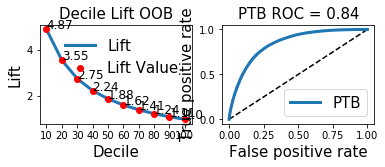

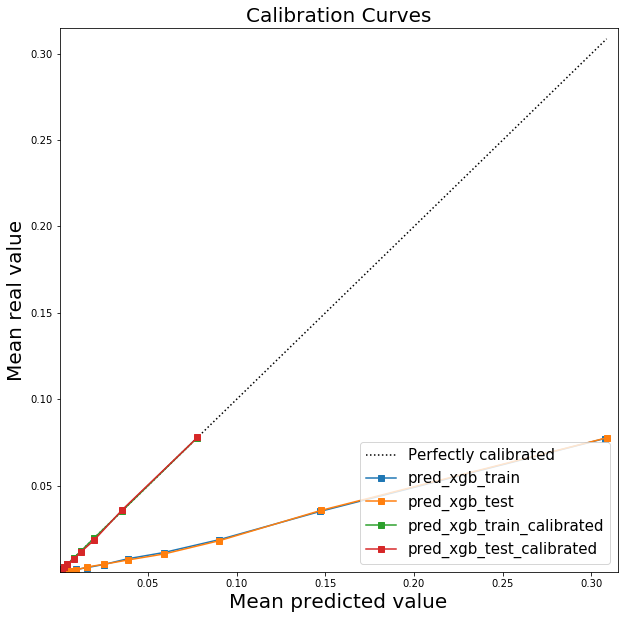

In [29]:
#Каллибровка
#данные с месячными откликами
import pandas as pd
import os
import cx_Oracle as orcl
os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
sql_str1 = '''select --+ parallel(8) 
     *
    from T_RS_CASH_ALL_SMS_score_0309 where FLAG_APPLICATION is not null'''
df_resp = pd.read_sql_query(sql_str1, connection)

import sys
sys.path.append('/home/python/2018_06_Card/utilites')
import MetricsUtils as mu
dcl = [10,20,30,40,50,60,70,80,90,100]
lift_df = mu.lift1(df_resp.FLAG_APPLICATION, df_resp.SCORE, dcl, isPlot = True)
lift_df

from importlib import reload
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
import numpy as np

pred_resp_train, pred_resp_test, Y_resp_train, Y_resp_test = train_test_split(df_resp.SCORE, df_resp.FLAG_APPLICATION, test_size=0.3, random_state = 20190201)

# calibration
ir = IsotonicRegression()
ir.fit(np.concatenate([pred_resp_train, [0,1]]), np.concatenate([Y_resp_train, [0,1]]))

# transform scores to probabilities
pred_new_train_calibrated = ir.transform(pred_resp_train)
pred_new_test_calibrated = ir.transform(pred_resp_test)

#save model
import pickle
pickle.dump(ir, open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_cash_01032019_ALL_ir_lern_21062019.dat", "wb"))

import sys
sys.path.append('./utilites')
import utilities as ut
#reload(ut)
#OOB
ut.showcc([#(df_resp.SCORE_CL,df_resp.IS_APPLICATION, 'calibr_'),
           (pred_resp_train, Y_resp_train, 'pred_xgb_train'),(pred_resp_test, Y_resp_test, 'pred_xgb_test'),
           (pred_new_train_calibrated, Y_resp_train, 'pred_xgb_train_calibrated'),
           (pred_new_test_calibrated, Y_resp_test, 'pred_xgb_test_calibrated') ])

## Scoring 04_2019

In [2]:
def save_file(df, sk_date_score):
    start_time = time.time()
    
    rows = df.to_records(index=False).tolist()

    cursor = orcl.Cursor(connection)
    cursor.prepare('''insert into T_RS_CASH_ALL_SMS_score_0409(skp_client,MONTH_,SCORE,SCORE_CL, SK_DATE_SCORE) values (:1, :2, :3, :4, ''' + str(sk_date_score) +''')''')
    cursor.executemany(None, rows)
    connection.commit()
    
    end_time = time.time()
    return (end_time-start_time)

import pandas as pd
import os
import cx_Oracle as orcl
connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM]/g#e44ep2d123@10.13.24.12:1521/HDWKZ.KZ.PROD')

def load_file(tile):
    connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM]/g#e44ep2d123@10.13.24.12:1521/HDWKZ.KZ.PROD')
    start_time = time.time()
    sql_str1 = '''select --+ parallel(8) 
    *
    from ap_Crm.T_RS_ABT_DATA_CASH_ALL_SMS0409
     WHERE n_tile={}'''.format(tile)
    df = pd.read_sql_query(sql_str1, connection)
    end_time = time.time()
    return (df,end_time-start_time)

In [6]:
%%time
import time
import numpy as np
import pandas as pd
import gc, re

#обучена на 01.0.201
ir = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_cash_01032019_ALL_ir_lern_21062019.dat", "rb"))

import pickle
clf = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_cash_all_sms_21062019_without_hyperopt.dat", "rb"))
features = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_features_cash_all_sms_21062019.dat", "rb"))

def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

for i in range(1,10+1):
    print( '{} iteration'.format(i))
    df_fin, time_load = load_file(i)
    print( 'time = ',time_load)

    #cat_features = pd.get_dummies(df_fin[cat_feat])
    #df_fin = df_fin.drop(cat_feat,axis = 1)
    #df_fin, _ , _ = prepare_df(df_fin,trsh_hold=0.001, isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #df_fin, df_categ_feat_ind, df_dummy_categ_feat_ind = prepare_df(df_fin,trsh_hold=0.001,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    df_fin, _ , _ = prepare_df_test_real(df_fin, features,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #target_fin = df_fin.IND_FULL_APP
    #cuid = df_fin.ID_CUID
    cuid = df_fin['SKP_CLIENT']
    #skp_campaign = df_fin['SKP_CAMPAIGN']
    date_month_valid_from = df_fin['MONTH_']
    #id_source = df_fin[ 'ID_SOURCE' ] 
    
    df_fin = df_fin[features]
    #gc.collect()
    X_oob = df_fin#.drop(['IND_FULL_APP'],axis=1)
    #Y_oob = df_fin.IND_FULL_APP
    
    print(X_oob.shape)
    
    #df_fin = df_fin.drop(['IND_FULL_APP','ID_CUID'],axis = 1)
    #df_fin = pd.concat([df_fin, cat_features[used_cat_cols]], axis=1)
    #df_fin = df_fin.drop(check_arr,axis=1)
    
    #-----------------------------------
    #pred = clf.predict_proba(df_fin.loc[:, selected_features])
    #pred_oob_xgb = xgp_feat_imp.predict(xgb.DMatrix(X_oob), ntree_limit=497+1)
    pred_oob_xgb =clf.predict_proba(X_oob, ntree_limit=5000 )[:,1]
    pred_oob_xgb_calibr = ir.transform(pred_oob_xgb)
    
    
    df1 = pd.concat([pd.DataFrame(cuid.values, columns=['SKP_CLIENT']).reset_index(drop=True), 
                     #pd.DataFrame(skp_campaign.values, columns=['SKP_CAMPAIGN']).reset_index(drop=True),
                    #pd.DataFrame(id_source.values, columns=['ID_SOURCE']).reset_index(drop=True),
                     pd.DataFrame(date_month_valid_from.apply(lambda x: to_integer(x)).values, columns=['MONTH_']).reset_index(drop=True),
                     pd.DataFrame(pred_oob_xgb, columns=['SCORE']).reset_index(drop=True)
                    ,pd.DataFrame(pred_oob_xgb_calibr, columns=['SCORE_CL']).reset_index(drop=True)
                    ], axis=1)
    print(df1.shape)
    #print 'roc-auc = ',metrics.roc_auc_score(target_fin, pred[:,1])
    #df = pd.DataFrame({'ID_CUID':cuid.values, 'score':pred[:,1],'IND_FULL_APP':target_fin})
    
    time_save = save_file(df1, to_integer(pd.to_datetime('today')))
    
    print (time_save)

1 iteration
time =  358.2560291290283
270 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
CMP_TYPE_PRODUCT_REFINANCE
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7373
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_CRM
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell ??
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_?????
COM_LAST_CALL_STATUS_?????????? ?????? ?? ?????????
COM_LAST_CALL_STATUS_???????????
COM_LAST_CALL_STATUS_??????????? ?????
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_002
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_011
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL_050
CON_CNT_PCC_ALL_060
CON_CNT_PCC_ALL_070
CON_CNT_PCC_ALL_100
CON_CNT_P

(388000, 124)
(388000, 4)
1.2995998859405518
3 iteration
time =  234.69858479499817
274 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
CMP_TYPE_PRODUCT_REFINANCE
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7373
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_CRM
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell ??
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_?????
COM_LAST_CALL_STATUS_?????????? ?????? ?? ?????????
COM_LAST_CALL_STATUS_???????????
COM_LAST_CALL_STATUS_??????????? ?????
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_002
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_011
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL_050
CON_CNT_PCC_ALL_060
CON

(388000, 124)
(388000, 4)
1.179309368133545
5 iteration
time =  239.99505186080933
276 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
CMP_TYPE_PRODUCT_REFINANCE
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7373
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell ??
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_?????
COM_LAST_CALL_STATUS_?????????? ?????? ?? ?????????
COM_LAST_CALL_STATUS_???????????
COM_LAST_CALL_STATUS_??????????? ?????
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_011
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_021
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL_050
CON_CNT_PCC_ALL_060
CON_CNT_PCC_ALL_070
CON_CNT

(388000, 124)
(388000, 4)
1.5218541622161865
7 iteration
time =  250.23137855529785
270 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
CMP_TYPE_PRODUCT_REFINANCE
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7373
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_CRM
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell ??
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_?????
COM_LAST_CALL_STATUS_?????????? ?????? ?? ?????????
COM_LAST_CALL_STATUS_???????????
COM_LAST_CALL_STATUS_??????????? ?????
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_002
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_011
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL_050
CON_CNT_PCC_ALL_060
CON

(388000, 124)
(388000, 4)
1.3987884521484375
9 iteration
time =  203.53398752212524
199 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell ??
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_?????
COM_LAST_CALL_STATUS_?????????? ?????? ?? ?????????
COM_LAST_CALL_STATUS_???????????
COM_LAST_CALL_STATUS_??????????? ?????
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL_100
CON_CNT_PCC_ALL_101
CON_CNT_PCC_ALL_110
CON_CNT_PCC_ALL_120
CON_CNT_PCC_ALL_130
CON_CNT_PCC_ALL_200
CON_CNT_PCC_ALL_201
CON_CNT_PCC_ALL_2

(394278, 124)
(394278, 4)
1.3807177543640137
CPU times: user 45min 53s, sys: 1min 49s, total: 47min 42s
Wall time: 46min 1s


Current size: [6.0, 4.0]


k      lift  precision       tp  num_samples  threshold
0   10.0  5.273060   0.096438  15160.0     157199.0   0.188731
1   20.0  3.676870   0.067246  21142.0     314399.0   0.109307
2   30.0  2.810554   0.051402  24241.0     471598.0   0.070992
3   40.0  2.269565   0.041508  26100.0     628798.0   0.047494
4   50.0  1.893358   0.034627  27217.0     785997.0   0.031158
5   60.0  1.619014   0.029610  27928.0     943197.0   0.020361
6   70.0  1.410634   0.025799  28389.0    1100396.0   0.012738
7   80.0  1.243217   0.022737  28594.0    1257596.0   0.007482
8   90.0  1.109759   0.020296  28715.0    1414795.0   0.003727
9  100.0  1.000000   0.018289  28750.0    1571995.0   0.000018

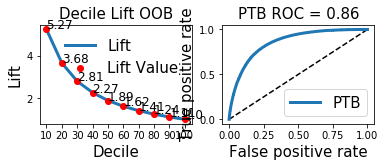

In [9]:
#Каллибровка
#данные с месячными откликами
import pandas as pd
import os
import cx_Oracle as orcl
os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
sql_str1 = '''select --+ parallel(8) 
     *
    from T_RS_CASH_ALL_SMS_score_0409 where FLAG_APPLICATION is not null'''
df_resp = pd.read_sql_query(sql_str1, connection)

import sys
sys.path.append('/home/python/2018_06_Card/utilites')
import MetricsUtils as mu
dcl = [10,20,30,40,50,60,70,80,90,100]
lift_df = mu.lift1(df_resp.FLAG_APPLICATION, df_resp.SCORE, dcl, isPlot = True)
lift_df

## Scoring 05_2019

In [18]:
def save_file(df, sk_date_score):
    start_time = time.time()
    
    rows = df.to_records(index=False).tolist()

    cursor = orcl.Cursor(connection)
    cursor.prepare('''insert into T_RS_CASH_ALL_SMS_score_0509(skp_client,MONTH_,SCORE,SCORE_CL, SK_DATE_SCORE) values (:1, :2, :3, :4, ''' + str(sk_date_score) +''')''')
    cursor.executemany(None, rows)
    connection.commit()
    
    end_time = time.time()
    return (end_time-start_time)

import pandas as pd
import os
import cx_Oracle as orcl
connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM]/g#e44ep2d123@10.13.24.12:1521/HDWKZ.KZ.PROD')

def load_file(tile):
    connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM]/g#e44ep2d123@10.13.24.12:1521/HDWKZ.KZ.PROD')
    start_time = time.time()
    sql_str1 = '''select --+ parallel(8) 
    *
    from ap_Crm.T_RS_ABT_DATA_CASH_ALL_SMS0509
     WHERE n_tile={}'''.format(tile)
    df = pd.read_sql_query(sql_str1, connection)
    end_time = time.time()
    return (df,end_time-start_time)

In [19]:
%%time
import time
import numpy as np
import pandas as pd
import gc, re

#обучена на 01.0.201
ir = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_cash_01032019_ALL_ir_lern_21062019.dat", "rb"))

import pickle
clf = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_cash_all_sms_21062019_without_hyperopt.dat", "rb"))
features = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_features_cash_all_sms_21062019.dat", "rb"))

def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

for i in range(1,10+1):
    print( '{} iteration'.format(i))
    df_fin, time_load = load_file(i)
    print( 'time = ',time_load)

    #cat_features = pd.get_dummies(df_fin[cat_feat])
    #df_fin = df_fin.drop(cat_feat,axis = 1)
    #df_fin, _ , _ = prepare_df(df_fin,trsh_hold=0.001, isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #df_fin, df_categ_feat_ind, df_dummy_categ_feat_ind = prepare_df(df_fin,trsh_hold=0.001,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    df_fin, _ , _ = prepare_df_test_real(df_fin, features,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #target_fin = df_fin.IND_FULL_APP
    #cuid = df_fin.ID_CUID
    cuid = df_fin['SKP_CLIENT']
    #skp_campaign = df_fin['SKP_CAMPAIGN']
    date_month_valid_from = df_fin['MONTH_']
    #id_source = df_fin[ 'ID_SOURCE' ] 
    
    df_fin = df_fin[features]
    #gc.collect()
    X_oob = df_fin#.drop(['IND_FULL_APP'],axis=1)
    #Y_oob = df_fin.IND_FULL_APP
    
    print(X_oob.shape)
    
    #df_fin = df_fin.drop(['IND_FULL_APP','ID_CUID'],axis = 1)
    #df_fin = pd.concat([df_fin, cat_features[used_cat_cols]], axis=1)
    #df_fin = df_fin.drop(check_arr,axis=1)
    
    #-----------------------------------
    #pred = clf.predict_proba(df_fin.loc[:, selected_features])
    #pred_oob_xgb = xgp_feat_imp.predict(xgb.DMatrix(X_oob), ntree_limit=497+1)
    pred_oob_xgb =clf.predict_proba(X_oob, ntree_limit=5000 )[:,1]
    pred_oob_xgb_calibr = ir.transform(pred_oob_xgb)
    
    
    df1 = pd.concat([pd.DataFrame(cuid.values, columns=['SKP_CLIENT']).reset_index(drop=True), 
                     #pd.DataFrame(skp_campaign.values, columns=['SKP_CAMPAIGN']).reset_index(drop=True),
                    #pd.DataFrame(id_source.values, columns=['ID_SOURCE']).reset_index(drop=True),
                     pd.DataFrame(date_month_valid_from.apply(lambda x: to_integer(x)).values, columns=['MONTH_']).reset_index(drop=True),
                     pd.DataFrame(pred_oob_xgb, columns=['SCORE']).reset_index(drop=True)
                    ,pd.DataFrame(pred_oob_xgb_calibr, columns=['SCORE_CL']).reset_index(drop=True)
                    ], axis=1)
    print(df1.shape)
    #print 'roc-auc = ',metrics.roc_auc_score(target_fin, pred[:,1])
    #df = pd.DataFrame({'ID_CUID':cuid.values, 'score':pred[:,1],'IND_FULL_APP':target_fin})
    
    time_save = save_file(df1, to_integer(pd.to_datetime('today')))
    
    print (time_save)

1 iteration
time =  226.50115776062012
272 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
CMP_TYPE_PRODUCT_REFINANCE
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7373
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_CRM
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell вх
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_Исключение номера из обработки
COM_LAST_CALL_STATUS_Неопределен
COM_LAST_CALL_STATUS_Перезвонить позже
COM_LAST_CALL_STATUS_Успех
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_002
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_011
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL_050
CON_CNT_PCC_ALL_060
CON_CNT_PCC_ALL_100
CON_CNT_PCC_ALL_101
CON_CNT_

(388000, 124)
(388000, 4)
1.0706937313079834
3 iteration
time =  236.6406750679016
276 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
CMP_TYPE_PRODUCT_REFINANCE
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7373
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_CRM
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell вх
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_Исключение номера из обработки
COM_LAST_CALL_STATUS_Неопределен
COM_LAST_CALL_STATUS_Перезвонить позже
COM_LAST_CALL_STATUS_Успех
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_002
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_011
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL_050
CON_CNT_PCC_ALL_060
CON_

(388000, 124)
(388000, 4)
0.9829528331756592
5 iteration
time =  212.44999647140503
268 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
CMP_TYPE_PRODUCT_REFINANCE
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7373
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_CRM
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell вх
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_Исключение номера из обработки
COM_LAST_CALL_STATUS_Неопределен
COM_LAST_CALL_STATUS_Перезвонить позже
COM_LAST_CALL_STATUS_Успех
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_002
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_011
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL_050
CON_CNT_PCC_ALL_060
CON

(388000, 124)
(388000, 4)
1.1605215072631836
7 iteration
time =  229.39227604866028
298 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
CMP_TYPE_PRODUCT_REFINANCE
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7373
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_CRM
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell вх
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_Исключение номера из обработки
COM_LAST_CALL_STATUS_Неопределен
COM_LAST_CALL_STATUS_Неуспех
COM_LAST_CALL_STATUS_Перезвонить позже
COM_LAST_CALL_STATUS_Успех
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_002
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_011
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_AL

(388000, 124)
(388000, 4)
0.9874856472015381
9 iteration
time =  170.60328769683838
202 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell вх
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_Исключение номера из обработки
COM_LAST_CALL_STATUS_Неопределен
COM_LAST_CALL_STATUS_Перезвонить позже
COM_LAST_CALL_STATUS_Успех
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL_100
CON_CNT_PCC_ALL_101
CON_CNT_PCC_ALL_110
CON_CNT_PCC_ALL_120
CON_CNT_PCC_ALL_130
CON_CNT_PCC_ALL_200
CON_CNT_PCC_ALL_201
CON_CNT_PCC_ALL_2

(429688, 124)
(429688, 4)
1.1317894458770752
CPU times: user 43min 31s, sys: 1min 42s, total: 45min 13s
Wall time: 41min 22s


Current size: [6.0, 4.0]


k      lift  precision       tp  num_samples  threshold
0   10.0  5.785220   0.090814  14172.0     156056.0   0.172918
1   20.0  3.863537   0.060648  18929.0     312113.0   0.096743
2   30.0  2.896414   0.045466  21286.0     468169.0   0.060525
3   40.0  2.314673   0.036335  22681.0     624226.0   0.039195
4   50.0  1.919255   0.030128  23508.0     780283.0   0.025305
5   60.0  1.633602   0.025643  24011.0     936339.0   0.015999
6   70.0  1.415625   0.022222  24275.0    1092396.0   0.009781
7   80.0  1.245357   0.019549  24406.0    1248452.0   0.005616
8   90.0  1.109841   0.017422  24469.0    1404509.0   0.002717
9  100.0  1.000000   0.015698  24497.0    1560566.0   0.000022

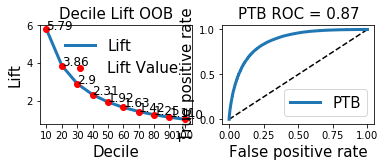

In [20]:
#Каллибровка
#данные с месячными откликами
import pandas as pd
import os
import cx_Oracle as orcl
os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
sql_str1 = '''select --+ parallel(8) 
     *
    from T_RS_CASH_ALL_SMS_score_0509 where FLAG_APPLICATION is not null'''
df_resp = pd.read_sql_query(sql_str1, connection)

import sys
sys.path.append('/home/python/2018_06_Card/utilites')
import MetricsUtils as mu
dcl = [10,20,30,40,50,60,70,80,90,100]
lift_df = mu.lift1(df_resp.FLAG_APPLICATION, df_resp.SCORE, dcl, isPlot = True)
lift_df

## Scoring 06_2019

In [22]:
def save_file(df, sk_date_score):
    start_time = time.time()
    
    rows = df.to_records(index=False).tolist()

    cursor = orcl.Cursor(connection)
    cursor.prepare('''insert into T_RS_CASH_ALL_SMS_score_0609(skp_client,MONTH_,SCORE,SCORE_CL, SK_DATE_SCORE) values (:1, :2, :3, :4, ''' + str(sk_date_score) +''')''')
    cursor.executemany(None, rows)
    connection.commit()
    
    end_time = time.time()
    return (end_time-start_time)

import pandas as pd
import os
import cx_Oracle as orcl
connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM]/g#e44ep2d123@10.13.24.12:1521/HDWKZ.KZ.PROD')

def load_file(tile):
    connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM]/g#e44ep2d123@10.13.24.12:1521/HDWKZ.KZ.PROD')
    start_time = time.time()
    sql_str1 = '''select --+ parallel(8) 
    *
    from ap_Crm.T_RS_ABT_DATA_CASH_ALL_SMS0609
     WHERE n_tile={}'''.format(tile)
    df = pd.read_sql_query(sql_str1, connection)
    end_time = time.time()
    return (df,end_time-start_time)

In [23]:
%%time
import time
import numpy as np
import pandas as pd
import gc, re

#обучена на 01.0.201
ir = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_cash_01032019_ALL_ir_lern_21062019.dat", "rb"))

import pickle
clf = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_cash_all_sms_21062019_without_hyperopt.dat", "rb"))
features = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_features_cash_all_sms_21062019.dat", "rb"))

def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

for i in range(1,10+1):
    print( '{} iteration'.format(i))
    df_fin, time_load = load_file(i)
    print( 'time = ',time_load)

    #cat_features = pd.get_dummies(df_fin[cat_feat])
    #df_fin = df_fin.drop(cat_feat,axis = 1)
    #df_fin, _ , _ = prepare_df(df_fin,trsh_hold=0.001, isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #df_fin, df_categ_feat_ind, df_dummy_categ_feat_ind = prepare_df(df_fin,trsh_hold=0.001,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    df_fin, _ , _ = prepare_df_test_real(df_fin, features,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #target_fin = df_fin.IND_FULL_APP
    #cuid = df_fin.ID_CUID
    cuid = df_fin['SKP_CLIENT']
    #skp_campaign = df_fin['SKP_CAMPAIGN']
    date_month_valid_from = df_fin['MONTH_']
    #id_source = df_fin[ 'ID_SOURCE' ] 
    
    df_fin = df_fin[features]
    #gc.collect()
    X_oob = df_fin#.drop(['IND_FULL_APP'],axis=1)
    #Y_oob = df_fin.IND_FULL_APP
    
    print(X_oob.shape)
    
    #df_fin = df_fin.drop(['IND_FULL_APP','ID_CUID'],axis = 1)
    #df_fin = pd.concat([df_fin, cat_features[used_cat_cols]], axis=1)
    #df_fin = df_fin.drop(check_arr,axis=1)
    
    #-----------------------------------
    #pred = clf.predict_proba(df_fin.loc[:, selected_features])
    #pred_oob_xgb = xgp_feat_imp.predict(xgb.DMatrix(X_oob), ntree_limit=497+1)
    pred_oob_xgb =clf.predict_proba(X_oob, ntree_limit=5000 )[:,1]
    pred_oob_xgb_calibr = ir.transform(pred_oob_xgb)
    
    
    df1 = pd.concat([pd.DataFrame(cuid.values, columns=['SKP_CLIENT']).reset_index(drop=True), 
                     #pd.DataFrame(skp_campaign.values, columns=['SKP_CAMPAIGN']).reset_index(drop=True),
                    #pd.DataFrame(id_source.values, columns=['ID_SOURCE']).reset_index(drop=True),
                     pd.DataFrame(date_month_valid_from.apply(lambda x: to_integer(x)).values, columns=['MONTH_']).reset_index(drop=True),
                     pd.DataFrame(pred_oob_xgb, columns=['SCORE']).reset_index(drop=True)
                    ,pd.DataFrame(pred_oob_xgb_calibr, columns=['SCORE_CL']).reset_index(drop=True)
                    ], axis=1)
    print(df1.shape)
    #print 'roc-auc = ',metrics.roc_auc_score(target_fin, pred[:,1])
    #df = pd.DataFrame({'ID_CUID':cuid.values, 'score':pred[:,1],'IND_FULL_APP':target_fin})
    
    time_save = save_file(df1, to_integer(pd.to_datetime('today')))
    
    print (time_save)

1 iteration
time =  242.8916516304016
296 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
CMP_TYPE_PRODUCT_REFINANCE
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7373
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell вх
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_Answer
COM_LAST_CALL_STATUS_Исключение номера из обработки
COM_LAST_CALL_STATUS_Неопределен
COM_LAST_CALL_STATUS_Перезвонить позже
COM_LAST_CALL_STATUS_Успех
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_011
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL_050
CON_CNT_PCC_ALL_060
CON_CNT_PCC_ALL_070
CON_CNT_PCC_ALL_080
CON_CNT_PCC_ALL_100
CON_

(388000, 124)
(388000, 4)
0.9266757965087891
3 iteration
time =  233.477201461792
287 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
CMP_TYPE_PRODUCT_REFINANCE
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7373
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_CRM
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell вх
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_Answer
COM_LAST_CALL_STATUS_Исключение номера из обработки
COM_LAST_CALL_STATUS_Неопределен
COM_LAST_CALL_STATUS_Перезвонить позже
COM_LAST_CALL_STATUS_Успех
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_002
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_011
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_021
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_0

(388000, 124)
(388000, 4)
0.9633276462554932
5 iteration
time =  236.74363780021667
290 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
CMP_TYPE_PRODUCT_REFINANCE
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7373
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_CRM
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell вх
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_Answer
COM_LAST_CALL_STATUS_Исключение номера из обработки
COM_LAST_CALL_STATUS_Неопределен
COM_LAST_CALL_STATUS_Перезвонить позже
COM_LAST_CALL_STATUS_Успех
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_002
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_011
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL

(388000, 124)
(388000, 4)
1.6618554592132568
7 iteration
time =  239.976793050766
266 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
CMP_TYPE_PRODUCT_REFINANCE
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7373
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_CRM
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell вх
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_Answer
COM_LAST_CALL_STATUS_Исключение номера из обработки
COM_LAST_CALL_STATUS_Неопределен
COM_LAST_CALL_STATUS_Перезвонить позже
COM_LAST_CALL_STATUS_Успех
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_002
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_011
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL_0

(388000, 124)
(388000, 4)
1.4290273189544678
9 iteration
time =  184.68751454353333
202 features left
CMP_RISK_GRADE_A
CMP_RISK_GRADE_B
CMP_RISK_GRADE_C
CMP_RISK_GRADE_D
CMP_RISK_GRADE_E
CMP_RISK_GRADE_F
CMP_RISK_GRADE_G
CMP_RISK_GRADE_H
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell вх
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_Answer
COM_LAST_CALL_STATUS_Исключение номера из обработки
COM_LAST_CALL_STATUS_Неопределен
COM_LAST_CALL_STATUS_Перезвонить позже
COM_LAST_CALL_STATUS_Успех
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL_100
CON_CNT_PCC_ALL_101
CON_CNT_PCC_ALL_110
CON_CNT_PCC_ALL_120
CON_CNT_PCC_ALL_130
CON_CNT_PCC_ALL_200
CON_CNT_PCC_ALL_201
CON_CNT_PCC_ALL_210
C

(460501, 124)
(460501, 4)
1.4304819107055664
CPU times: user 44min 55s, sys: 1min 45s, total: 46min 41s
Wall time: 42min 32s


Current size: [6.0, 4.0]


k      lift  precision       tp  num_samples  threshold
0   10.0  4.873383   0.077368  12026.0     155438.0   0.193276
1   20.0  3.545814   0.056292  17500.0     310877.0   0.112146
2   30.0  2.753041   0.043707  20381.0     466315.0   0.071942
3   40.0  2.237713   0.035525  22088.0     621754.0   0.047540
4   50.0  1.884670   0.029920  23254.0     777193.0   0.031081
5   60.0  1.616283   0.025660  23931.0     932631.0   0.019676
6   70.0  1.408657   0.022363  24333.0    1088070.0   0.011871
7   80.0  1.243416   0.019740  24547.0    1243508.0   0.007553
8   90.0  1.109941   0.017621  24651.0    1398947.0   0.004034
9  100.0  1.000000   0.015876  24677.0    1554386.0   0.000030

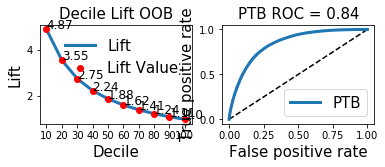

In [25]:
#Каллибровка
#данные с месячными откликами
import pandas as pd
import os
import cx_Oracle as orcl
os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
sql_str1 = '''select --+ parallel(8) 
     *
    from T_RS_CASH_ALL_SMS_score_0309 where FLAG_APPLICATION is not null'''
df_resp = pd.read_sql_query(sql_str1, connection)

import sys
sys.path.append('/home/python/2018_06_Card/utilites')
import MetricsUtils as mu
dcl = [10,20,30,40,50,60,70,80,90,100]
lift_df = mu.lift1(df_resp.FLAG_APPLICATION, df_resp.SCORE, dcl, isPlot = True)
lift_df

Current size: [6.0, 4.0]


k      lift  precision       tp  num_samples  threshold
0   10.0  5.275147   0.096476  15166.0     157199.0   0.192747
1   20.0  3.682609   0.067351  21175.0     314399.0   0.109884
2   30.0  2.820641   0.051586  24328.0     471598.0   0.069471
3   40.0  2.277913   0.041660  26196.0     628798.0   0.045118
4   50.0  1.899271   0.034736  27302.0     785997.0   0.029085
5   60.0  1.621623   0.029658  27973.0     943197.0   0.018450
6   70.0  1.411678   0.025818  28410.0    1100396.0   0.011193
7   80.0  1.244130   0.022754  28615.0    1257596.0   0.006416
8   90.0  1.109875   0.020298  28718.0    1414795.0   0.003097
9  100.0  1.000000   0.018289  28750.0    1571995.0   0.000018

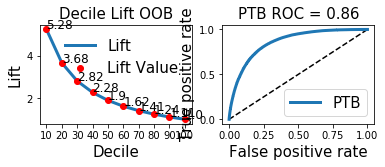

In [26]:
#Каллибровка
#данные с месячными откликами
import pandas as pd
import os
import cx_Oracle as orcl
os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
sql_str1 = '''select --+ parallel(8) 
     *
    from T_RS_CASH_ALL_SMS_score_0409 where FLAG_APPLICATION is not null'''
df_resp = pd.read_sql_query(sql_str1, connection)

import sys
sys.path.append('/home/python/2018_06_Card/utilites')
import MetricsUtils as mu
dcl = [10,20,30,40,50,60,70,80,90,100]
lift_df = mu.lift1(df_resp.FLAG_APPLICATION, df_resp.SCORE, dcl, isPlot = True)
lift_df

Current size: [6.0, 4.0]


k      lift  precision       tp  num_samples  threshold
0   10.0  5.785220   0.090814  14172.0     156056.0   0.172918
1   20.0  3.863537   0.060648  18929.0     312113.0   0.096743
2   30.0  2.896414   0.045466  21286.0     468169.0   0.060525
3   40.0  2.314673   0.036335  22681.0     624226.0   0.039195
4   50.0  1.919255   0.030128  23508.0     780283.0   0.025305
5   60.0  1.633602   0.025643  24011.0     936339.0   0.015999
6   70.0  1.415625   0.022222  24275.0    1092396.0   0.009781
7   80.0  1.245357   0.019549  24406.0    1248452.0   0.005616
8   90.0  1.109841   0.017422  24469.0    1404509.0   0.002717
9  100.0  1.000000   0.015698  24497.0    1560566.0   0.000022

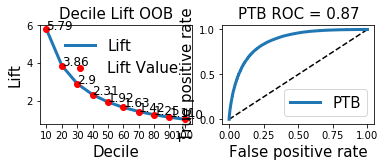

In [27]:
#Каллибровка
#данные с месячными откликами
import pandas as pd
import os
import cx_Oracle as orcl
os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
sql_str1 = '''select --+ parallel(8) 
     *
    from T_RS_CASH_ALL_SMS_score_0509 where FLAG_APPLICATION is not null'''
df_resp = pd.read_sql_query(sql_str1, connection)

import sys
sys.path.append('/home/python/2018_06_Card/utilites')
import MetricsUtils as mu
dcl = [10,20,30,40,50,60,70,80,90,100]
lift_df = mu.lift1(df_resp.FLAG_APPLICATION, df_resp.SCORE, dcl, isPlot = True)
lift_df

Current size: [6.0, 4.0]


k      lift  precision       tp  num_samples  threshold
0   10.0  4.790312   0.076050  11821.0     155438.0   0.496305
1   20.0  3.406820   0.054086  16814.0     310877.0   0.337495
2   30.0  2.643353   0.041965  19569.0     466316.0   0.238161
3   40.0  2.144003   0.034038  21163.0     621754.0   0.171109
4   50.0  1.805569   0.028665  22278.0     777193.0   0.125534
5   60.0  1.564007   0.024830  23157.0     932632.0   0.092634
6   70.0  1.378439   0.021884  23811.0    1088070.0   0.067949
7   80.0  1.227763   0.019492  24238.0    1243509.0   0.048785
8   90.0  1.104312   0.017532  24526.0    1398948.0   0.031926
9  100.0  1.000000   0.015876  24677.0    1554387.0   0.006252

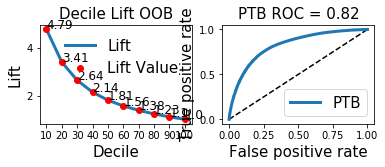

In [18]:
#Каллибровка
#данные с месячными откликами
import pandas as pd
import os
import cx_Oracle as orcl
os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
sql_str1 = '''select --+ parallel(8) 
     *
    from sh_cash_score_201903_clbr where IS_APPLICATION is not null'''
df_resp = pd.read_sql_query(sql_str1, connection)

import sys
sys.path.append('/home/python/2018_06_Card/utilites')
import MetricsUtils as mu
dcl = [10,20,30,40,50,60,70,80,90,100]
lift_df = mu.lift1(df_resp.IS_APPLICATION, df_resp.SCORE, dcl, isPlot = True)
lift_df

Current size: [6.0, 4.0]


k      lift  precision       tp  num_samples  threshold
0   10.0  4.830276   0.088340  13887.0     157199.0   0.502732
1   20.0  3.477043   0.063591  19993.0     314399.0   0.342050
2   30.0  2.685452   0.049114  23162.0     471598.0   0.241827
3   40.0  2.176000   0.039797  25024.0     628798.0   0.173546
4   50.0  1.826784   0.033410  26260.0     785997.0   0.126889
5   60.0  1.571420   0.028739  27107.0     943197.0   0.093419
6   70.0  1.381566   0.025267  27804.0    1100396.0   0.068422
7   80.0  1.229826   0.022492  28286.0    1257596.0   0.049068
8   90.0  1.105044   0.020210  28593.0    1414795.0   0.032076
9  100.0  1.000000   0.018289  28750.0    1571995.0   0.006252

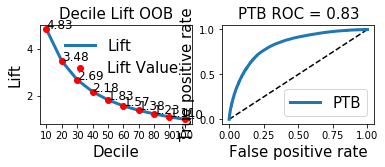

In [19]:
#Каллибровка
#данные с месячными откликами
import pandas as pd
import os
import cx_Oracle as orcl
os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
sql_str1 = '''select --+ parallel(8) 
     *
    from sh_cash_score_201904_clbr where IS_APPLICATION is not null'''
df_resp = pd.read_sql_query(sql_str1, connection)

import sys
sys.path.append('/home/python/2018_06_Card/utilites')
import MetricsUtils as mu
dcl = [10,20,30,40,50,60,70,80,90,100]
lift_df = mu.lift1(df_resp.IS_APPLICATION, df_resp.SCORE, dcl, isPlot = True)
lift_df

Current size: [6.0, 4.0]


k      lift  precision       tp  num_samples  threshold
0   10.0  5.041463   0.079136  12350.0     156060.0   0.499666
1   20.0  3.562486   0.055921  17454.0     312121.0   0.339916
2   30.0  2.735305   0.042936  20102.0     468182.0   0.240983
3   40.0  2.206089   0.034629  21617.0     624243.0   0.172466
4   50.0  1.845125   0.028963  22600.0     780304.0   0.126123
5   60.0  1.583256   0.024852  23271.0     936365.0   0.092883
6   70.0  1.388159   0.021790  23804.0    1092426.0   0.068173
7   80.0  1.233110   0.019356  24166.0    1248487.0   0.049024
8   90.0  1.105487   0.017353  24373.0    1404548.0   0.032087
9  100.0  1.000000   0.015697  24497.0    1560609.0   0.006183

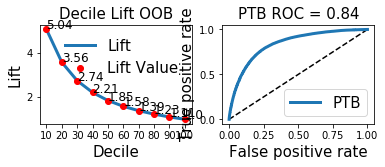

In [20]:
#Каллибровка
#данные с месячными откликами
import pandas as pd
import os
import cx_Oracle as orcl
os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
sql_str1 = '''select --+ parallel(8) 
     *
    from sh_cash_score_201905_clbr where IS_APPLICATION is not null'''
df_resp = pd.read_sql_query(sql_str1, connection)

import sys
sys.path.append('/home/python/2018_06_Card/utilites')
import MetricsUtils as mu
dcl = [10,20,30,40,50,60,70,80,90,100]
lift_df = mu.lift1(df_resp.IS_APPLICATION, df_resp.SCORE, dcl, isPlot = True)
lift_df

In [25]:
df_resp.head()

SKP_CLIENT    MONTH_     SCORE  SK_DATE_SCORE  FLAG_APPLICATION
0        8387  20190301  0.015387       20190621                 0
1       16175  20190301  0.048555       20190621                 0
2      280569  20190301  0.170636       20190621                 0
3      225735  20190301  0.006518       20190621                 0
4      161615  20190301  0.219048       20190621                 0

In [69]:
import pickle

In [70]:
features = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_features_cash_all_v1_sms_28062019.dat", "rb"))

In [71]:
features

Index(['CON_AMT_SUM_ANNUITY_POS', 'COM_CNT_CALLS_PROMISE_IN_6M',
       'COM_AVG_CALL_QUEUE_TLM', 'CON_IR_MIN_POS', 'PMT_MIN_BANK_12M',
       'WEB_AVG_OPEN_IB', 'FCB_SUM_AMT_CREDIT_W_MOR', 'CON_CNT_M_LAST_PAYMENT',
       'PMT_LP_CNT_HALYK_12M', 'SD_SHARE_INCOME_6_M_REG',
       ...
       'SD_NAME_REGION_Карагандинская', 'SD_NAME_REGION_Костанайская',
       'SD_NAME_REGION_Кызылординская', 'SD_NAME_REGION_Мангистауская',
       'SD_NAME_REGION_Павлодарская',
       'SD_NAME_REGION_Северо_minusКазахстанская',
       'SD_NAME_REGION_Южно_minusКазахстанская', 'SD_PREFERRED_LANGUAGE_XNA',
       'SD_PREFERRED_LANGUAGE_Казахский', 'SD_PREFERRED_LANGUAGE_Русский'],
      dtype='object', length=121)

In [72]:
list(features)

['CON_AMT_SUM_ANNUITY_POS',
 'COM_CNT_CALLS_PROMISE_IN_6M',
 'COM_AVG_CALL_QUEUE_TLM',
 'CON_IR_MIN_POS',
 'PMT_MIN_BANK_12M',
 'WEB_AVG_OPEN_IB',
 'FCB_SUM_AMT_CREDIT_W_MOR',
 'CON_CNT_M_LAST_PAYMENT',
 'PMT_LP_CNT_HALYK_12M',
 'SD_SHARE_INCOME_6_M_REG',
 'CON_AMT_SUM_CREDIT_POS_ZP',
 'FCB_SUM_ANNUITY_W_O_MOR',
 'PMT_AVG_DAYS_6M',
 'CON_SHARE_AMT_MED_LAST_3',
 'PMT_LP_SHARE_KAZPOST_12M',
 'CMP_AMT_OFFER',
 'COM_AVG_CALL_XS_QUEUE_TLM',
 'PMT_LP_CNT_TER_12M',
 'FCB_MIN_AMT_CREDIT',
 'FCB_CNT_CONTRACT_CARD',
 'CON_AVG_INS_PER_CONTRA',
 'WEB_CNT_M_LAST_RES_LH',
 'SD_AMT_INCOME_OTHER',
 'FCB_CNT_APP_12M',
 'FCB_CNT_APP_1M',
 'CON_SHARE_AMT_MED_LAST_2',
 'PMT_LP_MED_BANK_12M',
 'WEB_CNT_M_LAST_LH',
 'COM_SHARE_SUCCESS_6M',
 'FCB_CNT_CONTRACT_LOAN',
 'FCB_MAX_OVERDUE',
 'CON_SHARE_IR_MED_LAST_3',
 'PMT_LP_MED_DAYS_12M',
 'CON_CNT_MB_LAST_3',
 'CON_FLAG_HAS_CARD',
 'COM_CNT_M_LAST_CALL_SUCCESS',
 'PMT_LP_MAX_BANK_12M',
 'CON_IR_MAX_CASH',
 'LC_TERM',
 'CON_IR_MAX_POS',
 'APP_SHARE_REJ_CASH_36

In [74]:
features1 = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_features_cash_all_sms_21062019.dat", "rb"))
list(features1)

['CON_AMT_SUM_ANNUITY_POS',
 'COM_CNT_CALLS_PROMISE_IN_6M',
 'COM_AVG_CALL_QUEUE_TLM',
 'CON_IR_MIN_POS',
 'PMT_MIN_BANK_12M',
 'WEB_AVG_OPEN_IB',
 'FCB_SUM_AMT_CREDIT_W_MOR',
 'CON_CNT_M_LAST_PAYMENT',
 'PMT_LP_CNT_HALYK_12M',
 'SD_SHARE_INCOME_6_M_REG',
 'CON_AMT_SUM_CREDIT_POS_ZP',
 'FCB_SUM_ANNUITY_W_O_MOR',
 'PMT_AVG_DAYS_6M',
 'CON_SHARE_AMT_MED_LAST_3',
 'PMT_LP_SHARE_KAZPOST_12M',
 'CMP_AMT_OFFER',
 'COM_AVG_CALL_XS_QUEUE_TLM',
 'PMT_LP_CNT_TER_12M',
 'FCB_MIN_AMT_CREDIT',
 'FCB_CNT_CONTRACT_CARD',
 'CON_AVG_INS_PER_CONTRA',
 'WEB_CNT_M_LAST_RES_LH',
 'SD_AMT_INCOME_OTHER',
 'FCB_CNT_APP_12M',
 'FCB_CNT_APP_1M',
 'CON_SHARE_AMT_MED_LAST_2',
 'PMT_LP_MED_BANK_12M',
 'WEB_CNT_M_LAST_LH',
 'COM_SHARE_SUCCESS_6M',
 'FCB_CNT_CONTRACT_LOAN',
 'FCB_MAX_OVERDUE',
 'CON_SHARE_IR_MED_LAST_3',
 'PMT_LP_MED_DAYS_12M',
 'CON_CNT_MB_LAST_3',
 'CON_FLAG_HAS_CARD',
 'COM_CNT_M_LAST_CALL_SUCCESS',
 'PMT_LP_MAX_BANK_12M',
 'CON_IR_MAX_CASH',
 'LC_TERM',
 'CON_IR_MAX_POS',
 'APP_SHARE_REJ_CASH_36

In [85]:
[s for s in list(features) if "LAN" in s]

['FCB_AVG_TERM_PLAN',
 'SD_PREFERRED_LANGUAGE_XNA',
 'SD_PREFERRED_LANGUAGE_Казахский',
 'SD_PREFERRED_LANGUAGE_Русский']